# Feature engineering

In [1]:
# ----------------------------
# 1. Initial Setup and Data Loading
# ----------------------------
import pandas as pd
import numpy as np
import json
import pandas_ta as ta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load data
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

train_data = load_json_data('DataSet/train.json')
test_data = load_json_data('DataSet/test.json')

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data) if len(test_data) > 0 else pd.DataFrame()

# Convert and sort dates, set as index
if 'date' in train_df.columns:
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df = train_df.sort_values('date').set_index('date')
    
    if not test_df.empty and 'date' in test_df.columns:
        test_df['date'] = pd.to_datetime(test_df['date'])
        test_df = test_df.sort_values('date').set_index('date')

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape if not test_df.empty else 0}")

# ----------------------------
# 2. Feature Engineering Configuration
# ----------------------------

# We'll only use these price features (no close or adj_close)
PRICE_FEATURES_TO_LAG = ['open', 'high', 'low', 'volume']
LAG_PERIODS_PRICE = 3  # Only 3 days of lag for prices
LAG_PERIODS_NEWS = 1   # Only 1 day of lag for news

# ----------------------------
# 3. Feature Engineering Functions
# ----------------------------

def create_technical_indicators(df):
    """Create technical indicators using OPEN price only"""
    df = df.copy()
    
    # Ensure required columns exist
    for col in ['open', 'high', 'low', 'volume']:
        if col not in df.columns:
            df[col] = np.nan
    
    # Using OPEN price for all indicators
    price_series = df['open']
    
    # Simplified technical indicators
    df['sma_20'] = ta.sma(price_series, length=20)
    df['ema_20'] = ta.ema(price_series, length=20)
    df['rsi_14'] = ta.rsi(price_series, length=14)
    
    # MACD - using open price
    macd = ta.macd(price_series, fast=12, slow=26, signal=9)
    if macd is not None:
        df['macd'] = macd['MACD_12_26_9']
        df['macd_signal'] = macd['MACDs_12_26_9']
    
    # Bollinger Bands - using open price
    bb = ta.bbands(price_series, length=20)
    if bb is not None:
        df['bb_upper'] = bb['BBU_20_2.0']
        df['bb_lower'] = bb['BBL_20_2.0']
    
    return df

def create_date_features(df):
    """Create date-related features"""
    if not isinstance(df.index, pd.DatetimeIndex):
        return df
    
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_monday'] = (df['day_of_week'] == 0).astype(bool)
    df['is_friday'] = (df['day_of_week'] == 4).astype(bool)
    df['is_month_start'] = df.index.is_month_start.astype(bool)
    
    # Cyclic features
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    
    return df

def create_lagged_features(df, columns_to_lag, lag_periods):
    """Create lagged features for specified columns"""
    df = df.copy()
    for col in columns_to_lag:
        if col in df.columns:
            for lag in range(1, lag_periods + 1):
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def create_sentiment_features(df):
    """Extract and aggregate sentiment features from news_djia and news_reddit."""
    df = df.copy()
    # Helper to aggregate sentiment from a list of news items
    def aggregate_sentiment(news_list):
        if not isinstance(news_list, list) or len(news_list) == 0:
            return {'positive': 0, 'negative': 0, 'neutral': 0, 'spread': 0, 'count_pos': 0}
        pos = [item['finbert_sentiment']['positive'] for item in news_list if 'finbert_sentiment' in item]
        neg = [item['finbert_sentiment']['negative'] for item in news_list if 'finbert_sentiment' in item]
        neu = [item['finbert_sentiment']['neutral'] for item in news_list if 'finbert_sentiment' in item]
        return {
            'positive': np.mean(pos) if pos else 0,
            'negative': np.mean(neg) if neg else 0,
            'neutral': np.mean(neu) if neu else 0,
            'spread': (np.mean(pos) - np.mean(neg)) if pos and neg else 0,
            'count_pos': sum([1 for p in pos if p > 0.5]),
        }
    # DJIA
    djia_agg = df['news_djia'].apply(aggregate_sentiment) if 'news_djia' in df.columns else None
    if djia_agg is not None:
        df['djia_avg_positive'] = djia_agg.apply(lambda x: x['positive'])
        df['djia_avg_negative'] = djia_agg.apply(lambda x: x['negative'])
        df['djia_sentiment_spread'] = djia_agg.apply(lambda x: x['spread'])
        df['count_djia_pos'] = djia_agg.apply(lambda x: x['count_pos'])
    # Reddit
    reddit_agg = df['news_reddit'].apply(aggregate_sentiment) if 'news_reddit' in df.columns else None
    if reddit_agg is not None:
        df['reddit_avg_positive'] = reddit_agg.apply(lambda x: x['positive'])
        df['reddit_avg_negative'] = reddit_agg.apply(lambda x: x['negative'])
        df['reddit_sentiment_spread'] = reddit_agg.apply(lambda x: x['spread'])
        df['count_reddit_pos'] = reddit_agg.apply(lambda x: x['count_pos'])
    # Overall (average of DJIA and Reddit)
    for col in ['avg_positive', 'avg_negative', 'sentiment_spread']:
        djia_col = f'djia_{col}'
        reddit_col = f'reddit_{col}'
        overall_col = f'overall_{col}'
        if djia_col in df.columns and reddit_col in df.columns:
            df[overall_col] = df[[djia_col, reddit_col]].mean(axis=1)
    return df

def generate_features(df):
    """Generate all features for the dataset"""
    df = df.copy()
    
    # 1. Create basic features
    df = create_date_features(df)
    df = create_technical_indicators(df)
    
    # 2. Create sentiment features (if news exists)
    if any(col in df.columns for col in ['news_djia', 'news_reddit']):
        df = create_sentiment_features(df)
    
    # 3. Create lagged price features
    df = create_lagged_features(df, PRICE_FEATURES_TO_LAG, LAG_PERIODS_PRICE)
    
    # 4. Create lagged sentiment features (only 1 day)
    if any(col in df.columns for col in ['news_djia', 'news_reddit']):
        sentiment_cols = [c for c in df.columns if any(x in c for x in ['djia', 'reddit', 'sentiment'])]
        df = create_lagged_features(df, sentiment_cols, LAG_PERIODS_NEWS)
    
    return df

# ----------------------------
# 4. Combined Data Processing
# ----------------------------

def process_train_test(train_df, test_df):
    """Process both train and test data together for consistent features"""
    # Combine data while keeping track of which is which
    train_df['is_train'] = True
    test_df['is_train'] = False
    
    combined = pd.concat([train_df, test_df], axis=0)
    
    # Generate features on combined data
    combined_featured = generate_features(combined)
    
    # Split back into train and test
    train_featured = combined_featured[combined_featured['is_train'] == True].drop('is_train', axis=1)
    test_featured = combined_featured[combined_featured['is_train'] == False].drop('is_train', axis=1)
    
    return train_featured, test_featured

print("\nProcessing combined train and test data...")
train_featured, test_featured = process_train_test(train_df, test_df)

# ----------------------------
# 5. Feature Selection
# ----------------------------

def get_model_features(df):
    """Select only the features we want to use for lstm_lstm_lstm_lstm_lstm_lstm_lstm_lstm_lstm_lstm_lstm_lstm_modelmodelmodelmodeling"""
    features = []
    
    # Current day features
    features.append('open')  # Only current day feature we use
    
    # Date features
    date_features = ['day_of_week_sin', 'month_sin', 'is_monday', 'is_friday', 'is_month_start']
    features.extend([f for f in date_features if f in df.columns])
    
    # Technical indicators (no lags)
    tech_features = ['sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower']
    features.extend([f for f in tech_features if f in df.columns])
    
    # Price lags (only these get lagged features)
    for col in PRICE_FEATURES_TO_LAG:
        for lag in [1, 2, 3]:  # Only 3 days of lag
            lag_col = f'{col}_lag_{lag}'
            if lag_col in df.columns:
                features.append(lag_col)
    
    # Sentiment features (current day and 1 day lag)
    if any(col in df.columns for col in ['news_djia', 'news_reddit']):
        sentiment_features = ['overall_avg_positive', 'overall_avg_negative', 
                            'overall_sentiment_spread', 'count_djia_pos', 'count_reddit_pos']
        features.extend([f for f in sentiment_features if f in df.columns])
        
        # Add 1-day lags for sentiment
        for f in sentiment_features:
            lag_col = f'{f}_lag_1'
            if lag_col in df.columns:
                features.append(lag_col)
    
    return sorted(list(set(features)))

model_features = get_model_features(train_featured)
print(f"Selected {len(model_features)} features for modeling")

# ----------------------------
# 6. Save Processed Data
# ----------------------------

# Handle missing values: Drop them
null_rows = train_featured.isnull().any(axis=1)
print(f"Dropping {null_rows.sum()} rows with missing values")

train_featured = train_featured[~null_rows]

# Save to CSV
train_featured.to_csv('train_processed_features.csv')
print("Saved train_processed_features.csv")

if not test_featured.empty:
    test_featured.to_csv('test_processed_features.csv')
    print("Saved test_processed_features.csv")

Train shape: (1863, 9), Test shape: (126, 6)

Processing combined train and test data...
Selected 33 features for modeling
Dropping 33 rows with missing values
Saved train_processed_features.csv
Saved test_processed_features.csv


In [2]:
X_train = train_featured[model_features]
y_train = train_featured['close']  # Assuming 'close' is the target variable
X_test = test_featured[model_features]

In [3]:
# X_train_new = X_train
excluded_features = ['open', 'low_lag_1', 'high_lag_1', 'volume_lag_1', 'overall_avg_positive', 'overall_avg_negative', 'overall_sentiment_spread']
# X_train_new = X_train.drop(columns=excluded_features)
X_train_new = X_train.copy()
# X_train_new = X_train[['open', 'low_lag_1', 'high_lag_1', 'volume_lag_1', 'overall_avg_positive', 'overall_avg_negative', 'overall_sentiment_spread']]
# X_train_new = X_train[['open', 'sma_20', 'ema_20', 'rsi_14', 'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'open_lag_1', 'low_lag_1', 'high_lag_1', 'volume_lag_1', 'overall_avg_positive', 'overall_avg_negative', 'overall_sentiment_spread']]
# Exclude the features listed in excluded_features from X_train to create X_train_new



# Heuristic

MSE: 38781.59
MAE: 147.43
MedAE: 107.47
MAPE: 0.87%
R²: 0.8921


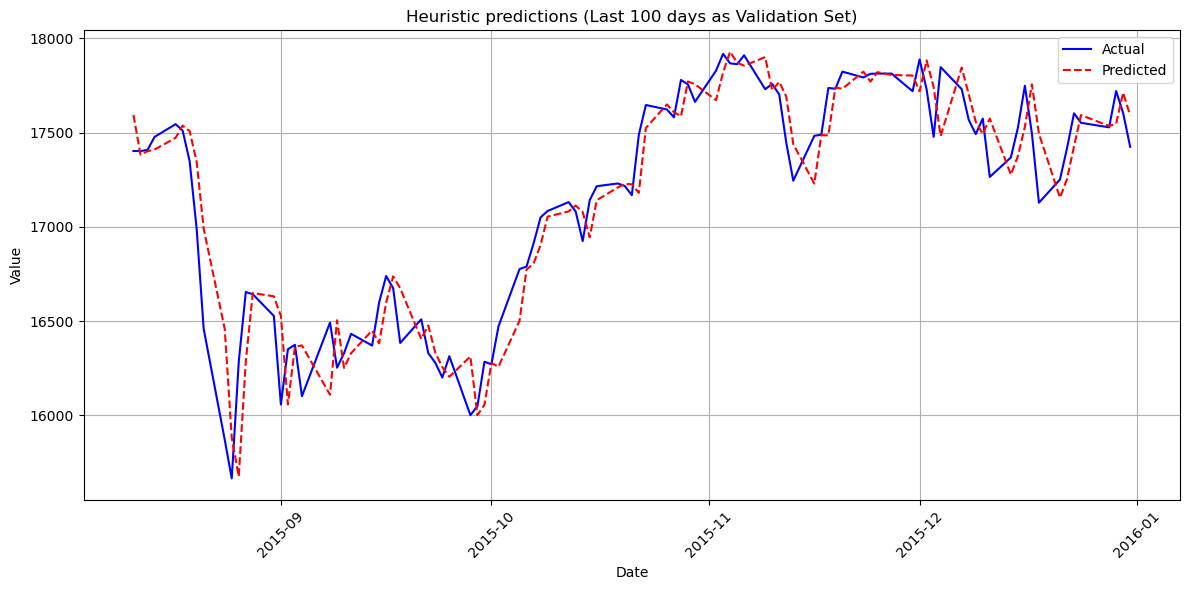

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

y_true = y_train[-100:]
y_pred = X_train['open'][-100:]

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MedAE: {medae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label='Actual', color='blue')
plt.plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Heuristic predictions (Last 100 days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# FB Prophet

In [5]:
#!pip install prophet
# additive_features = [
#     'ema_20', 'high_lag_1',
#     'low_lag_1', 'open',
#     'rsi_14', 'sma_20'
# ]
# multiplicative_features = [
#     'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3'
# ]

16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing


Validation MSE: 42279.36
Validation R²: 0.8824


(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

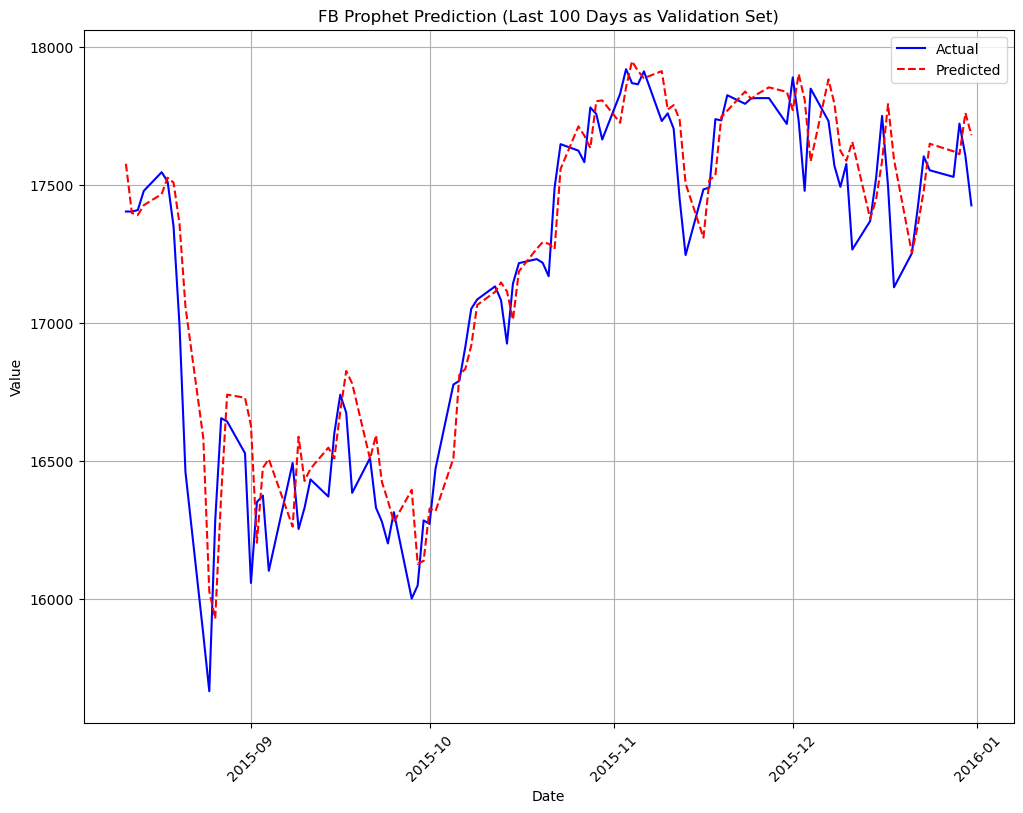

In [162]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Feature lists
# additive_features = [
#     'bb_lower', 'bb_upper', 'ema_20', 'high_lag_1', 'high_lag_2', 'high_lag_3',
#     'low_lag_1', 'low_lag_2', 'low_lag_3', 'macd', 'macd_signal', 'open',
#     'open_lag_1', 'open_lag_2', 'open_lag_3', 'rsi_14', 'sma_20'
# ]
additive_features = [
    'high_lag_1', 'high_lag_2', 
    'low_lag_2', 'low_lag_1', 
    
    'open',
    'bb_lower', 'bb_upper', 
    'ema_20', 
    'sma_20',
    # 'rsi_14',
    'macd',
    'macd_signal',
]

multiplicative_features = [
    # 'month_sin',
    'overall_avg_negative', 
    'overall_avg_positive', 
    # 'rsi_14',
    'volume_lag_1', 'volume_lag_2',
    # 'day_of_week_sin',
]

# multiplicative_features = [
#     'count_djia_pos', 'count_djia_pos_lag_1', 'count_reddit_pos', 'count_reddit_pos_lag_1',
#     'day_of_week_sin', 'is_friday', 'is_monday', 'is_month_start', 'month_sin',
#     'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread',
#     'overall_sentiment_spread_lag_1', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3'
# ]



all_features = additive_features + multiplicative_features

# Scale features
X_train_new = X_train.copy()
# scaler = MinMaxScaler()
# X_train_new[all_features] = scaler.fit_transform(X_train[all_features])

# Prepare Prophet DataFrame
prophet_df = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})

# Add all features as regressors
for col in all_features:
    prophet_df[col] = X_train_new[col].values

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = prophet_df.iloc[:-val_days]
val_fold = prophet_df.iloc[-val_days:]
final_val = val_fold.copy()

# Scale features for train and validation sets
scaler_fold = MinMaxScaler()
train_fold_scaled = train_fold.copy()
val_fold_scaled = val_fold.copy()
train_fold_scaled[all_features] = scaler_fold.fit_transform(train_fold[all_features])
val_fold_scaled[all_features] = scaler_fold.transform(val_fold[all_features])

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = True,
    seasonality_mode='additive',

)

# Add regressors
for col in all_features:
    if col in multiplicative_features:
        prophet_model.add_regressor(col, mode='multiplicative')
    if col in additive_features:
        prophet_model.add_regressor(col, mode='additive')

# Fit the model
prophet_model.fit(train_fold_scaled[['ds', 'y'] + all_features])

# Make predictions on validation set
val_preds = prophet_model.predict(val_fold_scaled[['ds'] + all_features])
final_val['prophet'] = val_preds['yhat'].values
# Evaluate predictions
mse = mean_squared_error(val_fold_scaled['y'], val_preds['yhat'])
r2 = r2_score(val_fold_scaled['y'], val_preds['yhat'])
print(f"Validation MSE: {mse:.2f}")
print(f"Validation R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold_scaled['ds'], val_fold_scaled['y'], label='Actual', color='blue')
plt.plot(val_fold_scaled['ds'], val_preds['yhat'], label='Predicted', color='red', linestyle='--')
plt.title('FB Prophet Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Save the plot
# plt.savefig('validation_predictions.png')

## Feat importance

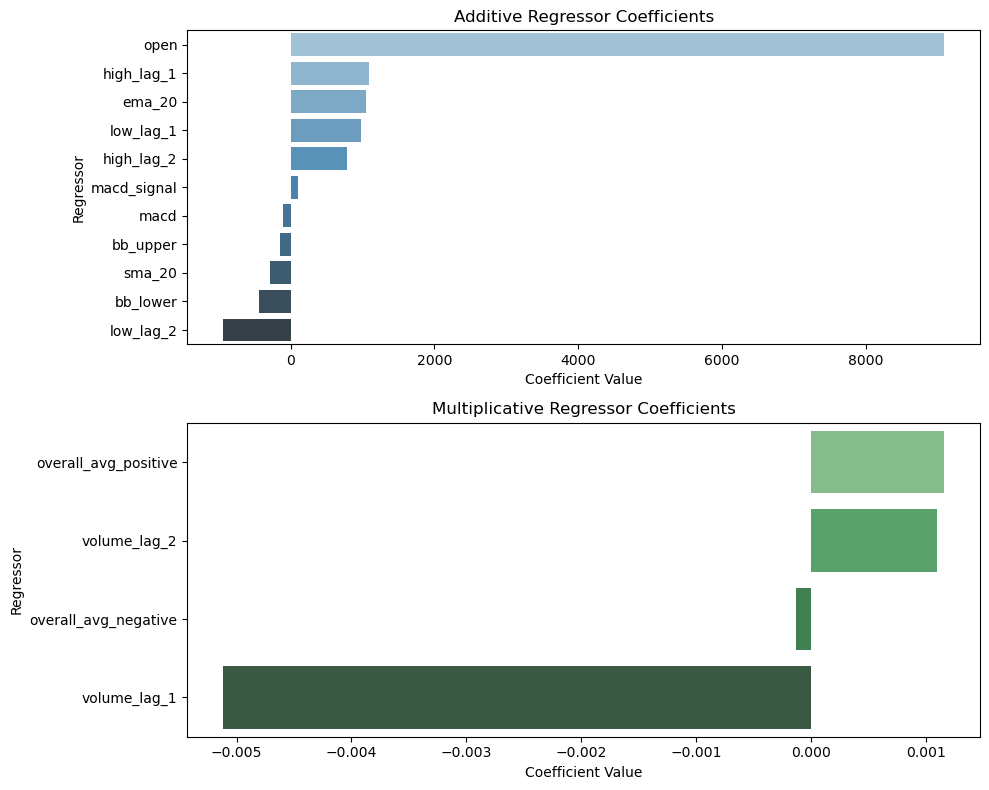

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.utilities import regressor_coefficients

# Get and sort the regressor coefficients
regressor_coef = regressor_coefficients(prophet_model)
regressor_coef = regressor_coef.sort_values('coef', ascending=False)

# Split by mode
additive_coefs = regressor_coef[regressor_coef['regressor_mode'] == 'additive']
multiplicative_coefs = regressor_coef[regressor_coef['regressor_mode'] == 'multiplicative']

# Plot setup
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Additive regressors plot
sns.barplot(x='coef', y='regressor', data=additive_coefs, ax=axes[0], palette='Blues_d')
axes[0].set_title('Additive Regressor Coefficients')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Regressor')

# Multiplicative regressors plot
sns.barplot(x='coef', y='regressor', data=multiplicative_coefs, ax=axes[1], palette='Greens_d')
axes[1].set_title('Multiplicative Regressor Coefficients')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Regressor')

plt.tight_layout()
plt.show()


## Test set inference

17:51:34 - cmdstanpy - INFO - Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing


Final model trained on full dataset with new scaler

Submission file 'prophet_submission.csv' has been created.


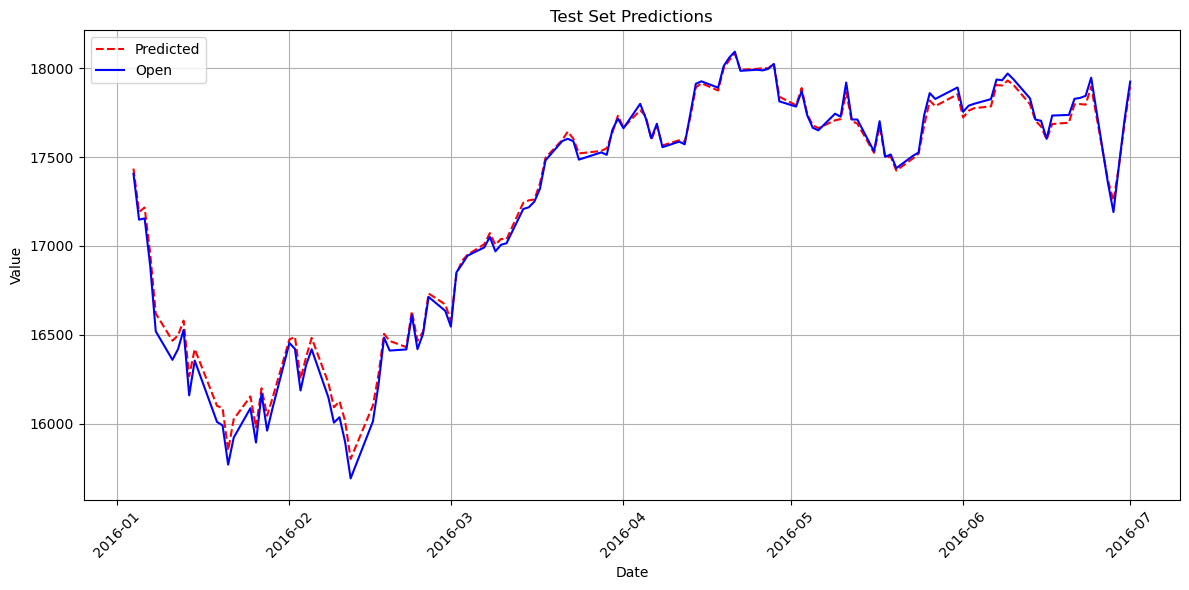

In [155]:
# Train final model on full dataset with new scaler
final_prophet_model = Prophet(
    seasonality_mode='multiplicative'
)

# Add all features as regressors for final model
for col in all_features:
    if col in multiplicative_features:
        final_prophet_model.add_regressor(col, mode='multiplicative')
    if col in additive_features:
        final_prophet_model.add_regressor(col, mode='additive')

# Create new scaler for full dataset
final_scaler = MinMaxScaler()
prophet_df_scaled = prophet_df.copy()
prophet_df_scaled[all_features] = final_scaler.fit_transform(prophet_df[all_features])

# Fit the final model on full data
final_prophet_model.fit(prophet_df_scaled[['ds', 'y'] + all_features])
print("Final model trained on full dataset with new scaler")

# Prepare test set
X_test_scaled = X_test.copy()
X_test_scaled[all_features] = final_scaler.transform(X_test[all_features])

# Prepare Prophet test DataFrame
prophet_test_df = pd.DataFrame({
    'ds': X_test_scaled.index
})
prophet_test_df['ds'] = pd.to_datetime(prophet_test_df['ds'])
for col in all_features:
    prophet_test_df[col] = X_test_scaled[col].values

# Make predictions on test set
test_preds = final_prophet_model.predict(prophet_test_df[['ds'] + all_features])

# Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(test_preds['ds'], test_preds['yhat'], label='Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Create submission DataFrame
test_preds['yhat_scaled'] = test_preds['yhat'] * 10**5
submission_df = pd.DataFrame({
    'ds': test_preds['ds'],
    'Close': test_preds['yhat_scaled']
})
# submission_df = pd.DataFrame({
#     'ds': X_test.index,
#     'Close': (X_test['open'] * 10**5).astype(int)
# })
submission_df = submission_df.sort_values(by='ds', ascending=False)
submission_df['Id'] = range(1, len(submission_df) + 1)
submission_df = submission_df[['Id', 'Close']]
submission_df.to_csv('prophet_submission.csv', index=False)
print("\nSubmission file 'prophet_submission.csv' has been created.")

# LGBM

LightGBM Validation MSE: 39461.54
LightGBM Validation R²: 0.8902
Heuristic (Open Price) Validation MSE: 38781.59
Heuristic (Open Price) Validation R²: 0.8921

Feature Importance:
      feature  importance
2        open         252
1   low_lag_1         107
0  high_lag_1          75


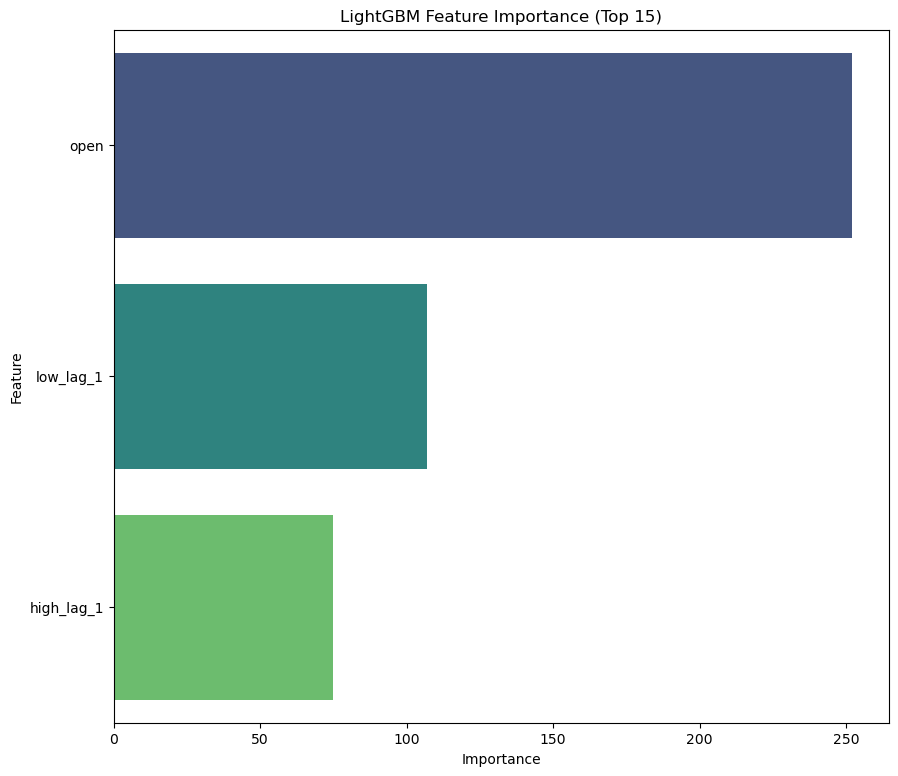

(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

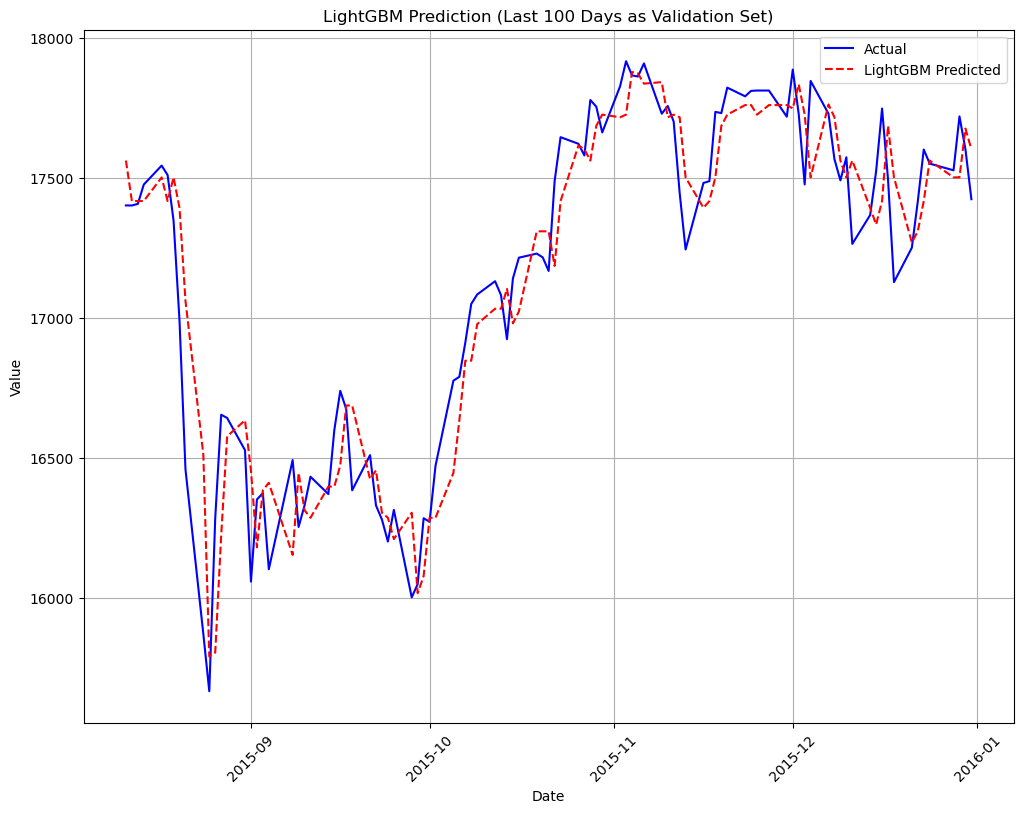

In [176]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# # Feature lists
# additive_features = [
#     'bb_lower', 'bb_upper', 'ema_20', 
#     'high_lag_1', 
#     'high_lag_2', 'high_lag_3',
#     'low_lag_1', 
#     'low_lag_2', 'low_lag_3', 
#     'macd', 
#     'macd_signal',
#     'open',
#     'open_lag_1', 
#     'open_lag_2', 
#     'open_lag_3',
#     'rsi_14', 'sma_20'
# ]


# multiplicative_features = [
#     'count_djia_pos', 'count_reddit_pos', 
#     'day_of_week_sin',
#     'is_friday', 'is_monday', 
#     'is_month_start',
#       'month_sin',
#     'overall_avg_negative', 'overall_avg_positive', 
#     'volume_lag_1', 
#     'volume_lag_2', 'volume_lag_3'
# ]
# Feature lists
additive_features = [
    # 'bb_lower', 
    # 'bb_upper', 
    # 'ema_20', 
    'high_lag_1', 
    # 'high_lag_2',
    # 'low_lag_2',
    'low_lag_1', 
    # 'macd', 
    # 'macd_signal', 
    'open',
    # 'open_lag_1', 
    # 'sma_20',
    #  'rsi_14'
]
multiplicative_features = [
    # 'day_of_week_sin', 
    # 'month_sin',
    # 'overall_avg_negative', 'overall_avg_positive',
    # 'volume_lag_1', 
    # 'volume_lag_2'
]
all_features = additive_features + multiplicative_features

# Assuming X_train, y_train are provided
# Add new features (example: volatility and momentum)
X_train_new = X_train.copy()
# X_train_new['volatility'] = X_train_new['high_lag_1'] - X_train_new['low_lag_1']
# X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
# all_features += ['momentum']

# Scale features with RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
# X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])

# Prepare data for LightGBM
train_data = pd.DataFrame({
    'y': y_train.values,
    **{col: X_train_scaled[col].values for col in all_features}
}, index=y_train.index)

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_params = {}
param_grid = {
    'num_leaves': [3],
    'learning_rate': [0.03],
    'min_child_samples': [20]  # Adjusted for more realistic values
}

# Hyperparameter tuning with cross-validation
for num_leaves in param_grid['num_leaves']:
    for lr in param_grid['learning_rate']:
        for min_child in param_grid['min_child_samples']:
            params = {
                'objective': 'regression',
                'metric': 'mse',
                'boosting_type': 'gbdt',
                'num_leaves': num_leaves,
                'learning_rate': lr,
                'min_child_samples': min_child,
                'lambda_l1': 0.1,  # L1 regularization
                'lambda_l2': 0.1,  # L2 regularization
                'feature_fraction': 0.8,
                # 'bagging_fraction': 0.8,
                # 'bagging_freq': 5,
                'verbose': -1,
                'random_state': 42
            }
            cv_mse = []
            for train_idx, val_idx in tscv.split(train_fold):
                cv_train = train_fold.iloc[train_idx]
                cv_val = train_fold.iloc[val_idx]
                lgb_train = lgb.Dataset(cv_train[all_features], label=cv_train['y'])
                lgb_val = lgb.Dataset(cv_val[all_features], label=cv_val['y'], reference=lgb_train)
                model = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_val],
                    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
                )
                cv_preds = model.predict(cv_val[all_features])
                cv_mse.append(mean_squared_error(cv_val['y'], cv_preds))
            avg_mse = np.mean(cv_mse)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = params

# Train final model with best parameters
lgb_train = lgb.Dataset(train_fold[all_features], label=train_fold['y'])
lgb_val = lgb.Dataset(val_fold[all_features], label=val_fold['y'], reference=lgb_train)
lgb_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Make predictions on validation set
val_preds_lgb = lgb_model.predict(val_fold[all_features])
final_val['lightgbm'] = val_preds_lgb
# Evaluate LightGBM predictions
mse_lgb = mean_squared_error(val_fold['y'], val_preds_lgb)
r2_lgb = r2_score(val_fold['y'], val_preds_lgb)
print(f"LightGBM Validation MSE: {mse_lgb:.2f}")
print(f"LightGBM Validation R²: {r2_lgb:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': lgb_model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 9))
sns.barplot(
    data=feature_importance.head(15),  # top 20 features
    x='importance', y='feature', palette='viridis'
)
plt.title('LightGBM Feature Importance (Top 15)')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_lgb, label='LightGBM Predicted', color='red', linestyle='--')
# plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('LightGBM Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Save the plot
# plt.savefig('improved_validation_predictions.png')

## Feat importance

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# Feature lists
additive_features = [
    'bb_lower', 
    'bb_upper', 
    'ema_20', 
    'high_lag_1',
    'low_lag_1', 
    'macd', 
    'macd_signal', 
    'open',
    'open_lag_1', 
    'sma_20',
     'rsi_14'
]
multiplicative_features = [
    'day_of_week_sin', 
    'month_sin',
    'overall_avg_negative', 'overall_avg_positive',
    'volume_lag_1', 'volume_lag_2'
]
all_features = additive_features + multiplicative_features

# Assuming X_train, y_train are provided
# Add new features (example: volatility and momentum)
X_train_new = X_train.copy()
# X_train_new['volatility'] = X_train_new['high_lag_1'] - X_train_new['low_lag_1']
X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
all_features += ['momentum']

# Scale features with RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
# X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])

# Prepare data for LightGBM
train_data = pd.DataFrame({
    'y': y_train.values,
    **{col: X_train_scaled[col].values for col in all_features}
}, index=y_train.index)

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_params = {}
param_grid = {
    'num_leaves': [4],
    'learning_rate': [0.03],
    'min_child_samples': [20]
}

# Hyperparameter tuning with cross-validation
for num_leaves in param_grid['num_leaves']:
    for lr in param_grid['learning_rate']:
        for min_child in param_grid['min_child_samples']:
            params = {
                'objective': 'regression',
                'metric': 'mse',
                'boosting_type': 'gbdt',
                'num_leaves': num_leaves,
                'learning_rate': lr,
                'min_child_samples': min_child,
                'lambda_l1': 0.1,  # L1 regularization
                'lambda_l2': 0.1,  # L2 regularization
                'feature_fraction': 0.8,
                # 'bagging_fraction': 0.8,
                # 'bagging_freq': 5,
                'verbose': -1,
                'random_state': 42
            }
            cv_mse = []
            for train_idx, val_idx in tscv.split(train_fold):
                cv_train = train_fold.iloc[train_idx]
                cv_val = train_fold.iloc[val_idx]
                lgb_train = lgb.Dataset(cv_train[all_features], label=cv_train['y'])
                lgb_val = lgb.Dataset(cv_val[all_features], label=cv_val['y'], reference=lgb_train)
                model = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_val],
                    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
                )
                cv_preds = model.predict(cv_val[all_features])
                cv_mse.append(mean_squared_error(cv_val['y'], cv_preds))
            avg_mse = np.mean(cv_mse)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = params

# Train final model with best parameters
lgb_train = lgb.Dataset(train_fold[all_features], label=train_fold['y'])
lgb_val = lgb.Dataset(val_fold[all_features], label=val_fold['y'], reference=lgb_train)
lgb_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Make predictions on validation set
val_preds_lgb = lgb_model.predict(val_fold[all_features])
final_val['lightgbm'] = val_preds_lgb
# Evaluate LightGBM predictions
mse_lgb = mean_squared_error(val_fold['y'], val_preds_lgb)
r2_lgb = r2_score(val_fold['y'], val_preds_lgb)
print(f"LightGBM Validation MSE: {mse_lgb:.2f}")
print(f"LightGBM Validation R²: {r2_lgb:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_lgb, label='LightGBM Predicted', color='red', linestyle='--')
plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('Actual vs Predicted Values (Last 126 Days Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
# plt.savefig('improved_validation_predictions.png')

## Test set inference


Submission file 'lgb_submission.csv' has been created.


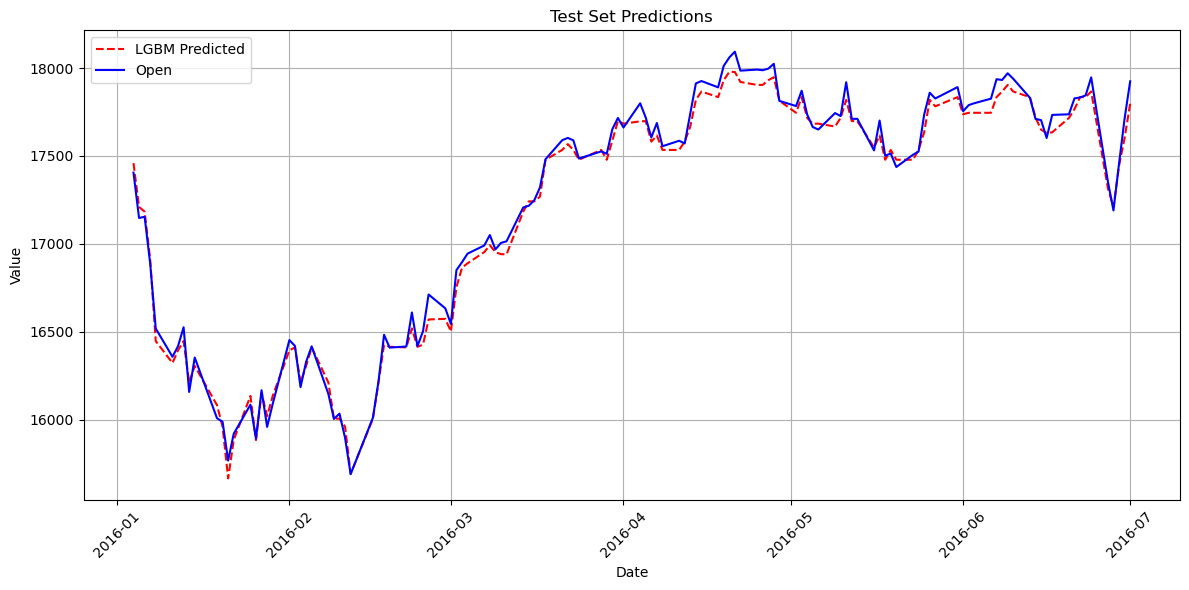

In [177]:
# ...existing code...

# 1. Add new features to X_train and X_test
X_train_new = X_train.copy()
X_test_new = X_test.copy()
# X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
# X_test_new['momentum'] = X_test_new['open'] - X_test_new['open_lag_1']
# all_features = additive_features + multiplicative_features + ['momentum']

# 2. Fit scaler on full training data, transform both train and test
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
X_test_scaled = X_test_new.copy()
X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])
X_test_scaled[all_features] = scaler.transform(X_test_new[all_features])

# 3. Retrain LGBM on all training data with best_params
lgb_full_train = lgb.Dataset(X_train_scaled[all_features], label=y_train)
final_lgb_model = lgb.train(
    best_params,
    lgb_full_train,
    num_boost_round=lgb_model.best_iteration   # Use best iteration from previous training
)

# 4. Predict on test set
test_preds_lgb = final_lgb_model.predict(X_test_scaled[all_features])

# 5. Prepare submission DataFrame
submission_df = pd.DataFrame({
    'ds': X_test.index,
    'Close': test_preds_lgb * 1e5  # scale if needed, adjust as per your requirements
})
submission_df = submission_df.sort_values(by='ds', ascending=False)
submission_df['Id'] = range(1, len(submission_df) + 1)
submission_df = submission_df[['Id', 'Close']]
submission_df.to_csv('lgb_submission.csv', index=False)
print("\nSubmission file 'lgb_submission.csv' has been created.")

# 6. Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, test_preds_lgb, label='LGBM Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('test_predictions.png')
# ...existing code...

# XGBoost

XGBoost Validation MSE: 42661.99
XGBoost Validation R²: 0.8813
Heuristic (Open Price) Validation MSE: 38781.59
Heuristic (Open Price) Validation R²: 0.8921

Feature Importance:
                                   feature    importance
high_lag_1                      high_lag_1  3.979429e+08
low_lag_1                        low_lag_1  2.354122e+08
open                                  open  1.932235e+08
ema_20                              ema_20  1.589531e+08
open_lag_1                      open_lag_1  1.277503e+07
bb_lower                          bb_lower  1.105643e+07
high_lag_2                      high_lag_2  8.991950e+06
low_lag_2                        low_lag_2  6.177502e+06
bb_upper                          bb_upper  4.156338e+06
sma_20                              sma_20  3.732171e+06
rsi_14                              rsi_14  2.477061e+05
macd                                  macd  2.125494e+05
momentum                          momentum  1.851018e+05
overall_avg_positive  ove

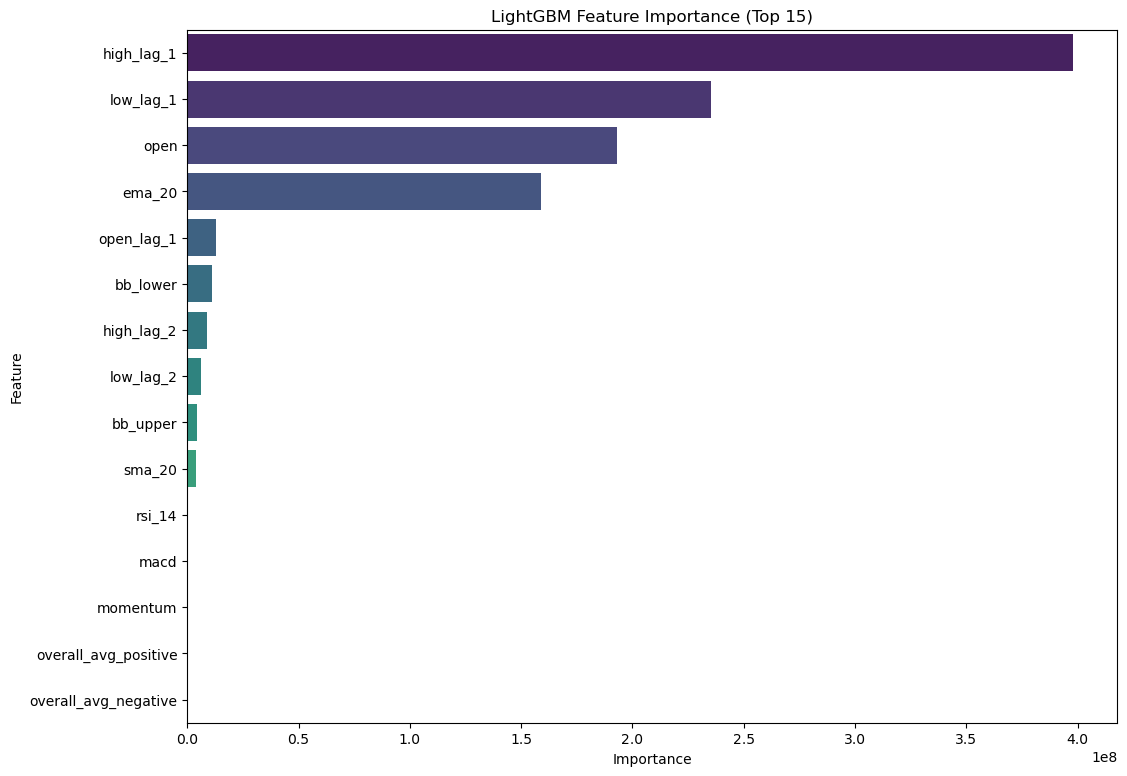

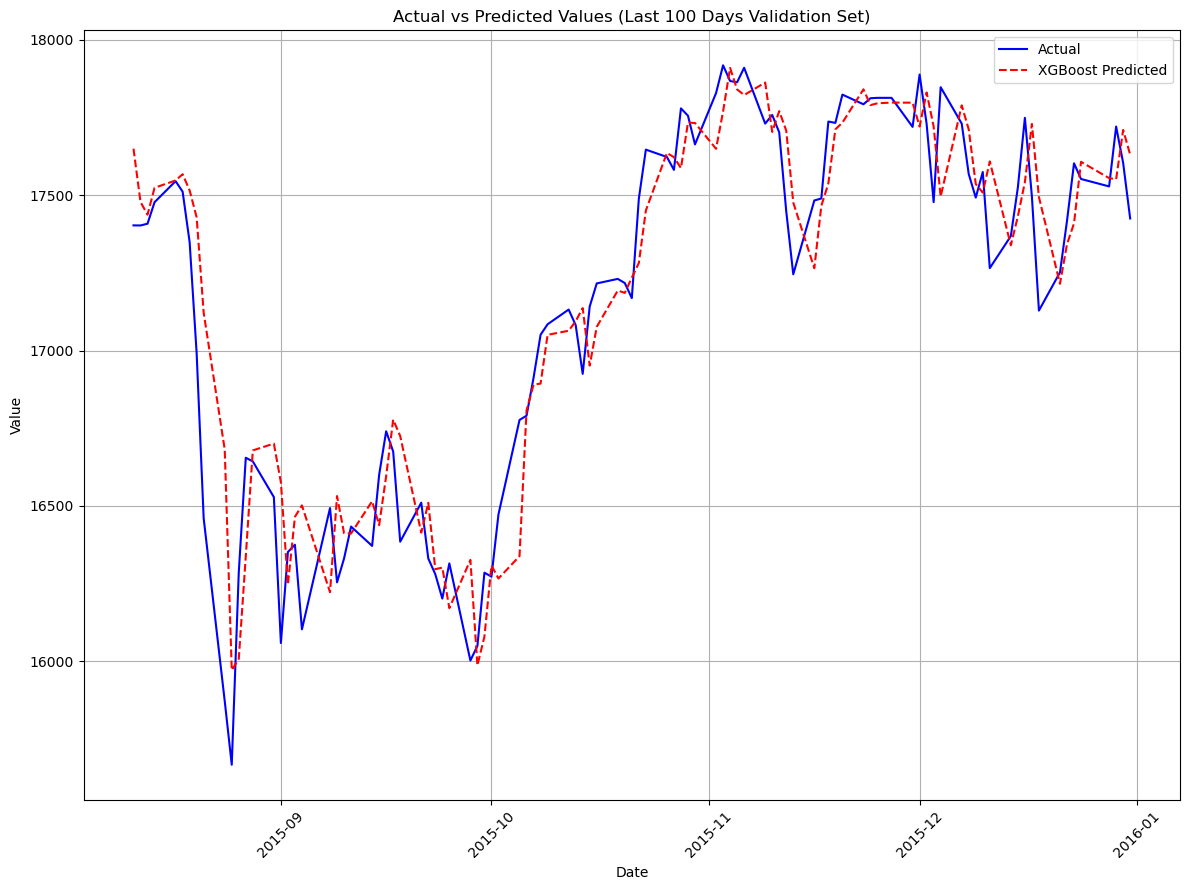

In [167]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# Feature lists
additive_features = [
    'bb_lower', 
    'bb_upper', 
    'ema_20', 
    'high_lag_1', 'high_lag_2',
    'low_lag_2',
    'low_lag_1', 
    'macd', 
    # 'macd_signal', 
    'open',
    'open_lag_1', 
    'sma_20',
     'rsi_14'
]
multiplicative_features = [
    # 'day_of_week_sin', 
    # 'month_sin',
    'overall_avg_negative', 'overall_avg_positive',
    # 'volume_lag_1', 'volume_lag_2'
]
# additive_features = [
#     'bb_lower', 'bb_upper', 'ema_20', 
#     'high_lag_1', 
#     'high_lag_2', 'high_lag_3',
#     'low_lag_1', 
#     'low_lag_2', 'low_lag_3', 
#     'macd', 
#     'macd_signal',
#     'open',
#     'open_lag_1', 
#     'open_lag_2', 
#     'open_lag_3',
#     'rsi_14', 'sma_20'
# ]


# multiplicative_features = [
#     'count_djia_pos', 'count_reddit_pos', 
#     'day_of_week_sin',
#     'is_friday', 'is_monday', 
#     'is_month_start',
#     'month_sin',
#     'overall_avg_negative', 'overall_avg_positive', 
#     'volume_lag_1', 
#     'volume_lag_2', 'volume_lag_3'
# ]
all_features = additive_features + multiplicative_features

# Assuming X_train, y_train are provided
# Add new features (volatility and momentum)
X_train_new = X_train.copy()
# X_train_new['volatility'] = X_train_new['high_lag_1'] - X_train_new['low_lag_1']
X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
all_features += ['momentum']

# Scale features with RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
# X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])

# Prepare data for XGBoost
train_data = pd.DataFrame({
    'y': y_train.values,
    **{col: X_train_scaled[col].values for col in all_features}
}, index=y_train.index)

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Prepare XGBoost datasets
dtrain = xgb.DMatrix(train_fold[all_features], label=train_fold['y'])
dval = xgb.DMatrix(val_fold[all_features], label=val_fold['y'])

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 0.1,  # L2 regularization
    'alpha': 0.1,   # L1 regularization
    'seed': 42
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Make predictions on validation set
val_preds_xgb = xgb_model.predict(dval)
final_val['xgboost'] = val_preds_xgb
# Evaluate XGBoost predictions
mse_xgb = mean_squared_error(val_fold['y'], val_preds_xgb)
r2_xgb = r2_score(val_fold['y'], val_preds_xgb)
print(f"XGBoost Validation MSE: {mse_xgb:.2f}")
print(f"XGBoost Validation R²: {r2_xgb:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': list(xgb_model.get_score(importance_type='gain').values())
}, index=list(xgb_model.get_score(importance_type='gain').keys())).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(12, 9))
sns.barplot(
    data=feature_importance.head(15),  # top 20 features
    x='importance', y='feature', palette='viridis'
)
plt.title('LightGBM Feature Importance (Top 15)')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_xgb, label='XGBoost Predicted', color='red', linestyle='--')
# plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('Actual vs Predicted Values (Last 100 Days Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
# plt.savefig('xgboost_validation_predictions.png')

## Test set inference


Submission file 'xgb_submission.csv' has been created.


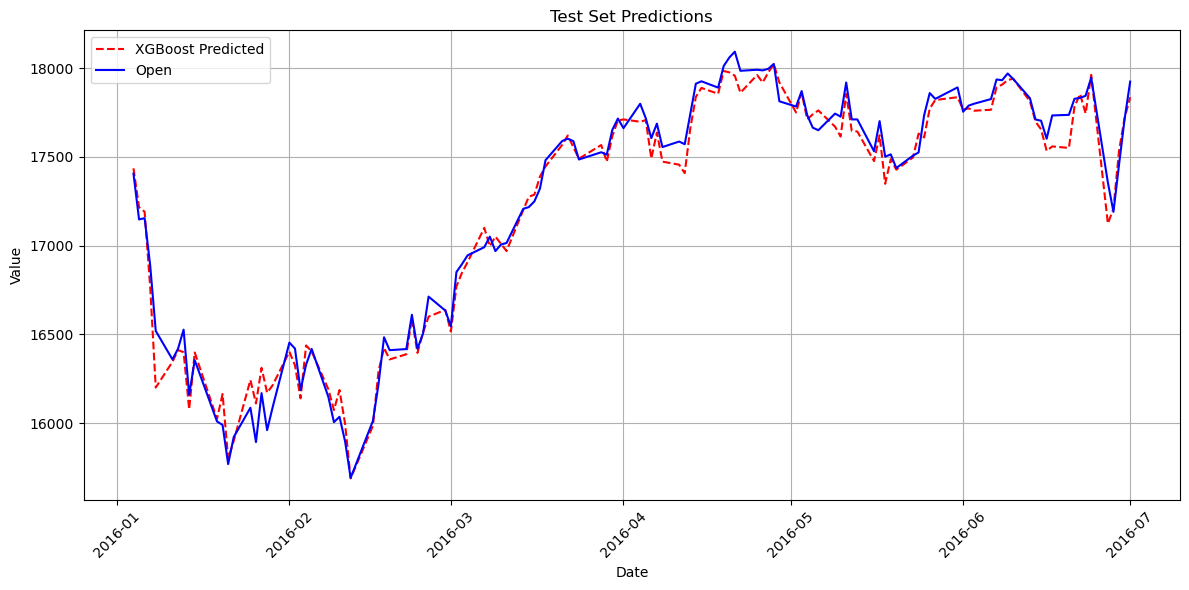

In [159]:
# ...existing code...

# 1. Add new features to X_train and X_test
X_train_new = X_train.copy()
X_test_new = X_test.copy()
X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
X_test_new['momentum'] = X_test_new['open'] - X_test_new['open_lag_1']
all_features = additive_features + multiplicative_features + ['momentum']

# 2. Fit scaler on full training data, transform both train and test
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
X_test_scaled = X_test_new.copy()
X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])
X_test_scaled[all_features] = scaler.transform(X_test_new[all_features])

# 3. Prepare XGBoost DMatrix for full training and test set
dtrain_full = xgb.DMatrix(X_train_scaled[all_features], label=y_train)
dtest = xgb.DMatrix(X_test_scaled[all_features])

# 4. Retrain XGBoost on all training data
final_xgb_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=model.best_iteration  # Use best iteration from previous training
)

# 5. Predict on test set
test_preds_xgb = final_xgb_model.predict(dtest)

# 6. Prepare submission DataFrame
submission_df = pd.DataFrame({
    'ds': X_test.index,
    'Close': test_preds_xgb * 1e5  # scale if needed, adjust as per your requirements
})
submission_df = submission_df.sort_values(by='ds', ascending=False)
submission_df['Id'] = range(1, len(submission_df) + 1)
submission_df = submission_df[['Id', 'Close']]
submission_df.to_csv('xgb_submission.csv', index=False)
print("\nSubmission file 'xgb_submission.csv' has been created.")

# 7. Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, test_preds_xgb, label='XGBoost Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('xgboost_test_predictions.png')
# ...existing code...

# Random Forest

Random Forest Validation MSE: 40542.65
Random Forest Validation R²: 0.8872
Heuristic (Open Price) Validation MSE: 38781.59
Heuristic (Open Price) Validation R²: 0.8921

Feature Importance:
                 feature  importance
6                   open    0.377077
4              low_lag_1    0.315351
3             high_lag_1    0.255303
1               bb_upper    0.034322
2                 ema_20    0.015380
0               bb_lower    0.000818
11             month_sin    0.000522
5                   macd    0.000309
7                 sma_20    0.000294
8                 rsi_14    0.000155
15              momentum    0.000154
10  overall_avg_positive    0.000123
9   overall_avg_negative    0.000120
12       day_of_week_sin    0.000043
14             is_monday    0.000020
13             is_friday    0.000009


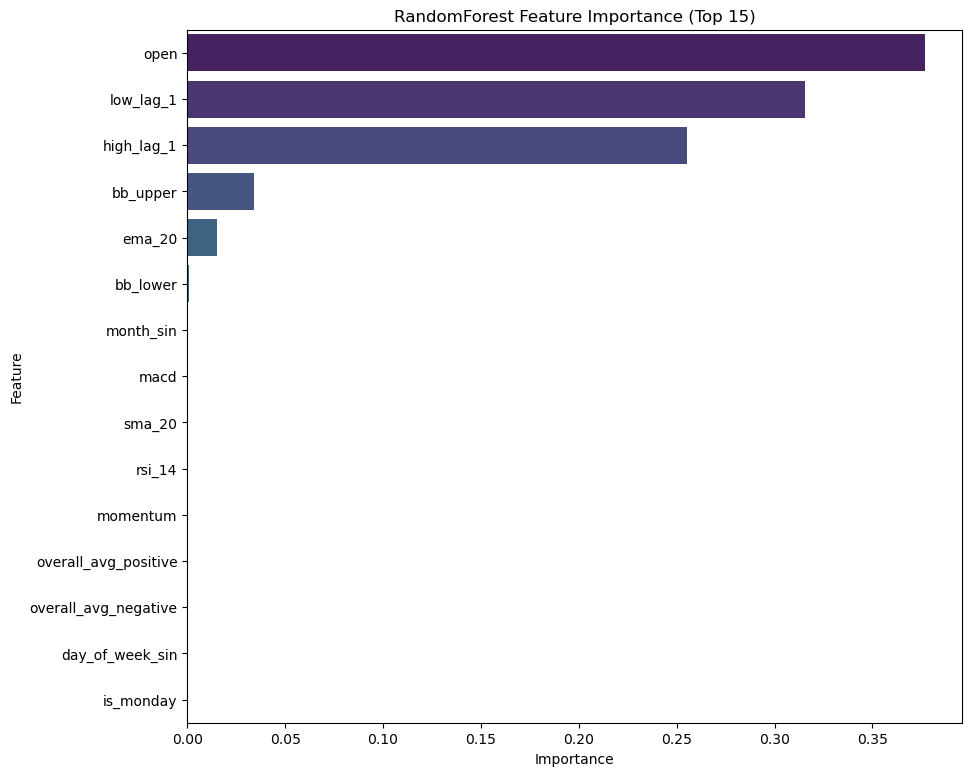

(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

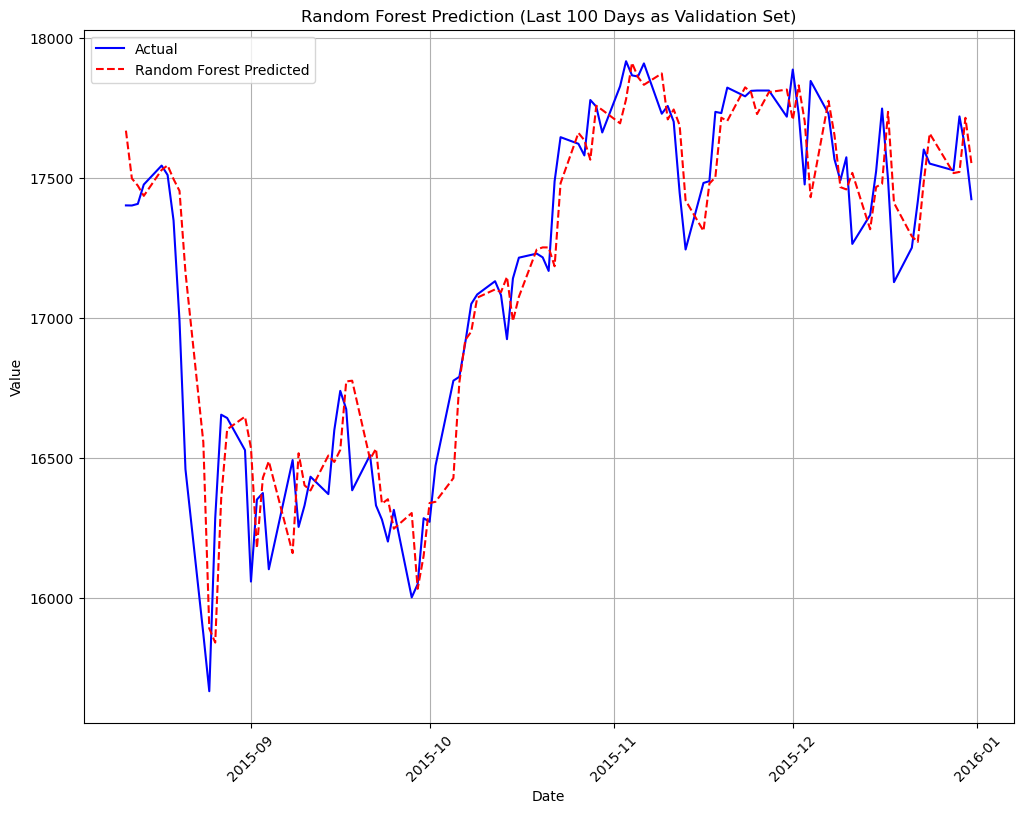

In [170]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# Feature lists (same as original)
additive_features = [
    'bb_lower', 
    'bb_upper', 
    'ema_20', 
    'high_lag_1', 
    # 'high_lag_2',
    # 'low_lag_2',
    'low_lag_1', 
    'macd', 
    # 'macd_signal',
    'open',
    # 'open_lag_1', 
    'sma_20',
    'rsi_14'
]
multiplicative_features = [
    'overall_avg_negative', 'overall_avg_positive',
    # 'volume_lag_1', 'volume_lag_2',
    'month_sin', 'day_of_week_sin', 'is_friday', 'is_monday'
]
# additive_features = [
#     'bb_lower', 'bb_upper', 'ema_20', 
#     'high_lag_1', 
#     'high_lag_2', 'high_lag_3',
#     'low_lag_1', 
#     'low_lag_2', 'low_lag_3', 
#     'macd', 
#     'macd_signal',
#     'open',
#     'open_lag_1', 
#     'open_lag_2', 
#     'open_lag_3',
#     'rsi_14', 'sma_20'
# ]


# multiplicative_features = [
#     'count_djia_pos', 'count_reddit_pos', 
#     'day_of_week_sin',
#     'is_friday', 'is_monday', 
#     'is_month_start',
#     'month_sin',
#     'overall_avg_negative', 'overall_avg_positive', 
#     'volume_lag_1', 
#     'volume_lag_2', 'volume_lag_3'
# ]
all_features = additive_features + multiplicative_features

# Assuming X_train, y_train are provided
# Add new features (momentum)
X_train_new = X_train.copy()
X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
all_features += ['momentum']

# Scale features with RobustScaler to handle outliers
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
# X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])

# Prepare data for Random Forest
train_data = pd.DataFrame({
    'y': y_train.values,
    **{col: X_train_scaled[col].values for col in all_features}
}, index=y_train.index)

# Split into train and validation (last 100 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Define Random Forest parameters
rf_params = {
    'n_estimators': 200,
    'max_depth': 32,
    # 'min_samples_split': 2,
    # 'min_samples_leaf': 1,
    'max_features': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

# Train the Random Forest model
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(train_fold[all_features], train_fold['y'])

# Make predictions on validation set
val_preds_rf = rf_model.predict(val_fold[all_features])
final_val['random_forest'] = val_preds_rf

# Evaluate Random Forest predictions
mse_rf = mean_squared_error(val_fold['y'], val_preds_rf)
r2_rf = r2_score(val_fold['y'], val_preds_rf)
print(f"Random Forest Validation MSE: {mse_rf:.2f}")
print(f"Random Forest Validation R²: {r2_rf:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)
# Plot feature importance
plt.figure(figsize=(10, 9))
sns.barplot(
    data=feature_importance.head(15),  # top 20 features
    x='importance', y='feature', palette='viridis'
)
plt.title('RandomForest Feature Importance (Top 15)')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.tight_layout()
plt.show()
# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_rf, label='Random Forest Predicted', color='red', linestyle='--')
# plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('Random Forest Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Save the plot (uncomment to save)
# plt.savefig('random_forest_validation_predictions.png')

## Test set inference


Submission file 'rf_submission.csv' has been created.


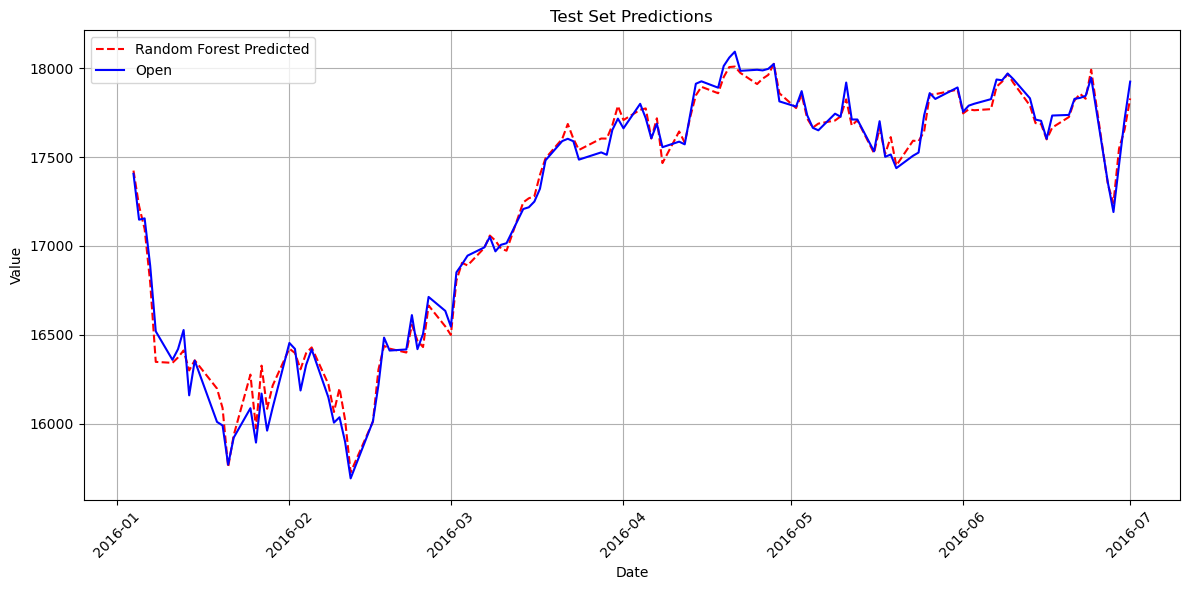

In [162]:
# ...existing code...

# 1. Add new features to X_train and X_test
X_train_new = X_train.copy()
X_test_new = X_test.copy()
X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
X_test_new['momentum'] = X_test_new['open'] - X_test_new['open_lag_1']
all_features = additive_features + multiplicative_features + ['momentum']

# 2. Fit scaler on full training data, transform both train and test
scaler = RobustScaler()
X_train_scaled = X_train_new.copy()
X_test_scaled = X_test_new.copy()
X_train_scaled[all_features] = scaler.fit_transform(X_train_new[all_features])
X_test_scaled[all_features] = scaler.transform(X_test_new[all_features])

# 3. Retrain Random Forest on all training data
rf_final_model = RandomForestRegressor(**rf_params)
rf_final_model.fit(X_train_scaled[all_features], y_train)

# 4. Predict on test set
test_preds_rf = rf_final_model.predict(X_test_scaled[all_features])

# 5. Prepare submission DataFrame
rf_submission_df = pd.DataFrame({
    'ds': X_test.index,
    'Close': test_preds_rf * 1e5  # scale if needed, adjust as per your requirements
})
rf_submission_df = rf_submission_df.sort_values(by='ds', ascending=False)
rf_submission_df['Id'] = range(1, len(rf_submission_df) + 1)
rf_submission_df = rf_submission_df[['Id', 'Close']]
rf_submission_df.to_csv('rf_submission.csv', index=False)
print("\nSubmission file 'rf_submission.csv' has been created.")

# 6. Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, test_preds_rf, label='Random Forest Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('random_forest_test_predictions.png')
# ...existing code...

# Google TFT

In [ ]:
#!pip install pytorch-forecasting

   ---------------------------------------- 0.0/197.7 kB ? eta -:--:--
   ------------ --------------------------- 61.4/197.7 kB 3.2 MB/s eta 0:00:01
   ------------------------------------- -- 184.3/197.7 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 197.7/197.7 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/819.0 kB ? eta -:--:--
   ------------ -------------------------- 256.0/819.0 kB 15.4 MB/s eta 0:00:01
   --------------------------- ------------ 563.2/819.0 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 819.0/819.0 kB 7.4 MB/s eta 0:00:00


In [40]:
# Ensure these are installed:
# !pip install pytorch-forecasting pytorch-lightning -q

import pandas as pd
import numpy as np
import torch
from lightning.pytorch import Trainer
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor # Optional
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import NormalDistributionLoss # Using NLL for point + uncertainty, or use MAE/MSE for pure point
# from torch.nn import MSELoss # Alternative for pure point prediction

# --- 0. Assuming these variables are pre-defined from your notebook: ---
# train_featured: DataFrame with training data and all engineered features, 'close' as target, DatetimeIndex
# test_featured: DataFrame with test data and all engineered features, DatetimeIndex
# model_features: List of feature names selected for modeling (excluding 'close' target)
# date_features: List of date-related feature names (e.g., 'day_of_week_sin', 'month_sin', etc.)
# Feature lists
additive_features = [
    'bb_lower', 'bb_upper', 'ema_20', 'high_lag_1',
    'low_lag_1', 'macd', 'macd_signal', 'open',
    'open_lag_1', 'rsi_14', 'sma_20'
]

multiplicative_features = [
    'day_of_week_sin', 'is_friday', 'is_monday', 'is_month_start', 'month_sin',
    'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread',
    'volume_lag_1'
]
# additive_features = [
#     'ema_20', 'high_lag_1',
#     'low_lag_1', 'open',
#     'rsi_14', 'sma_20'
# ]
# multiplicative_features = [
#     'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3'
# ]

all_features = additive_features + multiplicative_features
# Make sure 'close' is the target and not in model_features used as covariates
TARGET_COL = 'close'
if TARGET_COL in all_features:
    model_features_tft = [f for f in all_features if f != TARGET_COL] 
else:
    model_features_tft = all_features.copy()

print("Starting TFT Modeling Process...")
# --- 1. Data Preparation for TFT ---

# Create a copy for TFT data processing
train_data_tft = train_featured.copy()
test_data_tft_orig = test_featured.copy() # Keep original test features for submission date alignment

# Add a 'time_idx' column - essential for TFT
train_data_tft['time_idx'] = range(len(train_data_tft))

# Add a 'group_id' column - needed even for a single time series
GROUP_ID_COL = 'stock_id'
train_data_tft[GROUP_ID_COL] = 'stockA'

# Define date features that are known in advance
# This list should match the date-related features from your get_model_features function
date_features_for_tft = ['day_of_week_sin', 'month_sin', 'is_monday', 'is_friday', 'is_month_start']

# Identify feature types for TFT
time_varying_known_reals = [f for f in date_features_for_tft if f in train_data_tft.columns and f in model_features_tft]

time_varying_unknown_reals = [f for f in model_features_tft if f not in time_varying_known_reals and f in train_data_tft.columns]

# Ensure all features in model_features_tft are categorized
categorized_features = set(time_varying_known_reals + time_varying_unknown_reals)
for f in model_features_tft:
    if f not in categorized_features and f in train_data_tft.columns :
        # Defaulting uncategorized existing model features to unknown if missed (should not happen with current logic)
        print(f"Warning: Feature '{f}' from model_features_tft was not categorized, adding to unknown_reals.")
        time_varying_unknown_reals.append(f)

print(f"Time-varying known reals: {time_varying_known_reals}")
print(f"Time-varying unknown reals: {time_varying_unknown_reals}")

# Define encoder and prediction lengths
max_encoder_length = 30
max_prediction_length = len(test_featured)

print(f"Max Encoder Length: {max_encoder_length}, Max Prediction Length: {max_prediction_length}")

training_dataset = TimeSeriesDataSet(
    train_data_tft,
    time_idx='time_idx',
    target=TARGET_COL,
    group_ids=[GROUP_ID_COL],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(groups=[GROUP_ID_COL]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

batch_size = 32
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

tft_model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.01,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.05,
    hidden_continuous_size=64,
    loss=NormalDistributionLoss(),
    optimizer="adamw",
)
print(f"Number of parameters in TFT network: {tft_model.size()/1e3:.1f}k")

trainer = Trainer(
    max_epochs=200,
    accelerator="gpu",
    gradient_clip_val=0.1,
)

print("Starting TFT model training...")
trainer.fit(
    tft_model,
    train_dataloaders=train_dataloader,
)
print("TFT model training finished.")


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True


Starting TFT Modeling Process...
Time-varying known reals: ['day_of_week_sin', 'month_sin', 'is_monday', 'is_friday', 'is_month_start']
Time-varying unknown reals: ['bb_lower', 'bb_upper', 'ema_20', 'high_lag_1', 'low_lag_1', 'macd', 'macd_signal', 'open', 'open_lag_1', 'rsi_14', 'sma_20', 'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread', 'volume_lag_1']
Max Encoder Length: 30, Max Prediction Length: 126
Number of parameters in TFT network: 1627.1k


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | NormalDistributionLoss          | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 3.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 77.8 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 572 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 157 K  | train
7  | static_context_variable_selection  | GatedResidual

Starting TFT model training...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


TFT model training finished.


In [42]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Loading best TFT model from: {best_model_path}")
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# --- 1. Prepare encoder and decoder data ---
print("Preparing encoder data...")
encoder_data = train_data_tft[train_data_tft['time_idx'] > train_data_tft['time_idx'].max() - max_encoder_length].copy()

print("Preparing decoder data...")
last_train_time_idx = train_data_tft['time_idx'].max()
decoder_data = test_data_tft_orig.copy()
decoder_data['time_idx'] = range(last_train_time_idx + 1, last_train_time_idx + 1 + len(decoder_data))
decoder_data[GROUP_ID_COL] = 'stockA'
decoder_data[TARGET_COL] = 0.0

# Ensure all necessary features are present in decoder_data
# Use the *original* feature lists from the training cell (cell 0d55119a)
# These variables (time_varying_known_reals, time_varying_unknown_reals) are assumed to be in scope.
# Static reals and all categoricals were [] in the training setup.
original_static_reals = [] # Based on training_dataset setup
original_features_for_decoder = time_varying_known_reals + \
                                time_varying_unknown_reals + \
                                original_static_reals

for col in original_features_for_decoder:
    if col not in decoder_data.columns and col in test_data_tft_orig.columns:
        decoder_data[col] = test_data_tft_orig[col]
    elif col not in decoder_data.columns:
        print(f"Warning: Feature column '{col}' not found in decoder_data or test_data_tft_orig. Filling with 0.")
        decoder_data[col] = 0

print("Concatenating encoder and decoder data for prediction input...")
prediction_input_df = pd.concat([encoder_data, decoder_data], ignore_index=True)

# --- 2. Define the exact set of raw input columns expected by TimeSeriesDataSet ---
# These are the columns that `prediction_input_df` MUST contain.
# Use the original configuration from `training_dataset` for non-feature columns,
# and the *original feature lists* (from cell 0d55119a) for feature columns.

expected_raw_input_columns = []
expected_raw_input_columns.append(training_dataset.time_idx) # e.g., 'time_idx'
expected_raw_input_columns.extend(training_dataset.group_ids) # e.g., ['stock_id']
expected_raw_input_columns.append(training_dataset.target)     # e.g., 'close'

# Add original feature lists (these should be in scope from cell 0d55119a)
# Static and categorical features were defined as empty lists [] in training.
expected_raw_input_columns.extend([]) # Original static_categoricals
expected_raw_input_columns.extend(original_static_reals) # Original static_reals (was [])
expected_raw_input_columns.extend([]) # Original time_varying_known_categoricals
expected_raw_input_columns.extend(time_varying_known_reals) # Original list from training cell
expected_raw_input_columns.extend([]) # Original time_varying_unknown_categoricals
expected_raw_input_columns.extend(time_varying_unknown_reals) # Original list from training cell

expected_raw_input_columns = sorted(list(set(expected_raw_input_columns)))

print(f"Raw input columns expected by TimeSeriesDataSet constructor: {expected_raw_input_columns}")
print("Columns available in concatenated prediction_input_df:", sorted(list(prediction_input_df.columns)))

# --- 3. Validate and filter prediction_input_df ---
missing_columns = [col for col in expected_raw_input_columns if col not in prediction_input_df.columns]
if missing_columns:
    raise ValueError(f"Missing expected raw input columns in prediction_input_df: {missing_columns}. "
                     f"Available columns: {sorted(list(prediction_input_df.columns))}")

filtered_prediction_input_df = prediction_input_df[expected_raw_input_columns].copy()

print("Columns in filtered_prediction_input_df (passed to TSD) and their NaN counts:")
for col in filtered_prediction_input_df.columns:
    print(f"- {col}: {filtered_prediction_input_df[col].isna().sum()} NaNs, dtype: {filtered_prediction_input_df[col].dtype}")

# --- 4. Create TimeSeriesDataSet for prediction ---
print("Creating TimeSeriesDataSet for prediction...")
prediction_dataset = TimeSeriesDataSet(
    data=filtered_prediction_input_df,  # This DataFrame should NOT have relative_time_idx etc.
    time_idx=training_dataset.time_idx,
    target=training_dataset.target,
    group_ids=training_dataset.group_ids,
    max_encoder_length=training_dataset.max_encoder_length,
    max_prediction_length=training_dataset.max_prediction_length,
    
    # Pass the *original* feature lists (from cell 0d55119a)
    static_categoricals=[], # As used in training_dataset
    static_reals=original_static_reals, # As used in training_dataset (was [])
    time_varying_known_categoricals=[], # As used in training_dataset
    time_varying_known_reals=time_varying_known_reals,       # Use original list
    time_varying_unknown_categoricals=[], # As used in training_dataset
    time_varying_unknown_reals=time_varying_unknown_reals,   # Use original list
    
    # Pass the fitted normalizer and other flags from the training_dataset
    target_normalizer=training_dataset.target_normalizer,
    add_relative_time_idx=training_dataset.add_relative_time_idx, # Should be True
    add_target_scales=training_dataset.add_target_scales,       # Should be True
    add_encoder_length=training_dataset.add_encoder_length,     # Should be True
    allow_missing_timesteps=training_dataset.allow_missing_timesteps,
    
    # Set prediction specific flags
    predict_mode=True,
    randomize_length=None
)

# --- 5. Create DataLoader and make predictions ---
print("Creating DataLoader for prediction...")
predict_dataloader = prediction_dataset.to_dataloader(
    train=False,
    batch_size=batch_size * 2, # Can be larger for prediction
    num_workers=0,
    shuffle=False
)

print("Making predictions with TFT model...")
# The `predict` method of the model can take a DataLoader
raw_predictions_output = best_tft_model.predict(
    predict_dataloader,
    mode="prediction" # "prediction" for point forecasts, "quantiles" for quantile forecasts
)

# Assuming 'prediction' mode returns a tuple, and the first element is the tensor of predictions
# For NormalDistributionLoss, this will be the mean of the distribution.
predicted_values_normalized = raw_predictions_output[0].cpu().numpy() # [batch_size, n_timesteps_to_predict]

# --- 6. Post-process predictions (invert normalization) ---
print("Post-processing predictions...")

if isinstance(training_dataset.target_normalizer, GroupNormalizer):
    actual_group_value = 'stockA'  # As defined in your training data
    
    # Get parameters using the get_parameters() method
    norm_params = training_dataset.target_normalizer.get_parameters([actual_group_value])

    if norm_params is not None and actual_group_value in norm_params:
        group_specific_params = norm_params[actual_group_value]
        center = group_specific_params.get('center')
        scale = group_specific_params.get('scale')

        if center is not None and scale is not None:
            # If center and scale are tensors/numpy arrays, convert to float if necessary
            if hasattr(center, 'item'):
                center = center.item()
            if hasattr(scale, 'item'):
                scale = scale.item()

            y_transformed_pred = (predicted_values_normalized * scale) + center
            
            # Inverse softplus transformation: log(exp(x) - 1)
            exp_y_transformed_pred = np.exp(y_transformed_pred)
            arg_for_log = exp_y_transformed_pred - 1.0
            arg_for_log = np.maximum(arg_for_log, 1e-9) # Ensure positive argument for log
            final_predictions_tft = np.log(arg_for_log)
        else:
            print(f"Warning: 'center' or 'scale' not found in normalizer parameters for group '{actual_group_value}'. Inverse transform might be incorrect.")
            final_predictions_tft = predicted_values_normalized # Fallback
    else:
        print(f"Warning: Group '{actual_group_value}' not found in normalizer.get_parameters(). Inverse transform might be incorrect.")
        final_predictions_tft = predicted_values_normalized # Fallback
else:
    print("Warning: Unknown or unhandled target normalizer type. Inverse transform might be incorrect.")
    final_predictions_tft = predicted_values_normalized

# --- 7. Create submission file ---
print("Creating submission file...")
submission_df_tft = pd.DataFrame({
    'ds': test_data_tft_orig.index, # Use original test set index for dates
    'Close': final_predictions_tft.flatten()* 10**5 # Ensure it's a 1D array
})

submission_df_tft = submission_df_tft.sort_values(by='ds', ascending=False)
submission_df_tft['Id'] = range(1, len(submission_df_tft) + 1)
submission_df_tft = submission_df_tft[['Id', 'Close']]

print("\nSubmission DataFrame (TFT):")
print(submission_df_tft.head())

submission_df_tft.to_csv('tft_submission.csv', index=False)
print("\nSubmission file 'tft_submission.csv' has been created.")

Loading best TFT model from: d:\course\PTKD\EDA-Business-Analytics\lightning_logs\version_0\checkpoints\epoch=199-step=10400.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Preparing encoder data...
Preparing decoder data...
Concatenating encoder and decoder data for prediction input...
Raw input columns expected by TimeSeriesDataSet constructor: ['bb_lower', 'bb_upper', 'close', 'day_of_week_sin', 'ema_20', 'high_lag_1', 'is_friday', 'is_monday', 'is_month_start', 'low_lag_1', 'macd', 'macd_signal', 'month_sin', 'open', 'open_lag_1', 'overall_avg_negative', 'overall_avg_positive', 'overall_sentiment_spread', 'rsi_14', 'sma_20', 'stock_id', 'time_idx', 'volume_lag_1']
Columns available in concatenated prediction_input_df: ['adj_close', 'bb_lower', 'bb_upper', 'close', 'count_djia_pos', 'count_djia_pos_lag_1', 'count_reddit_pos', 'count_reddit_pos_lag_1', 'day_of_week', 'day_of_week_sin', 'djia_avg_negative', 'djia_avg_negative_lag_1', 'djia_avg_positive', 'djia_avg_positive_lag_1', 'djia_sentiment_spread', 'djia_sentiment_spread_lag_1', 'ema_20', 'high', 'high_lag_1', 'high_lag_2', 'high_lag_3', 'is_friday', 'is_monday', 'is_month_start', 'label', 'low', 

# DeepAR

In [ ]:
#!pip install gluonts

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 656.4 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.5 MB 1.0 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.5 MB 1.5 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 2.0 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 2.9 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.5 MB 3.8 MB/s eta 0:00:01
   ------------------------------- -------- 1.2/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.4 MB/s eta 0:00:00


## 1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                    | Out sizes    
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.6 M  | train | [[1, 1], [1, 1], [1, 59, 4], [1, 59], [1, 59], [1, 126, 4]] | [1, 100, 126]
----------------------------------------------------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.220     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 9.19237 (best 9.19237), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_1\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.26120 (best 8.26120), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_1\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.23053 (best 8.23053), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_1\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.15315 (best 8.15315), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_1\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 8.14100 (best 8.14100), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightnin

Validation MSE: 844830.01, R²: -1.4022


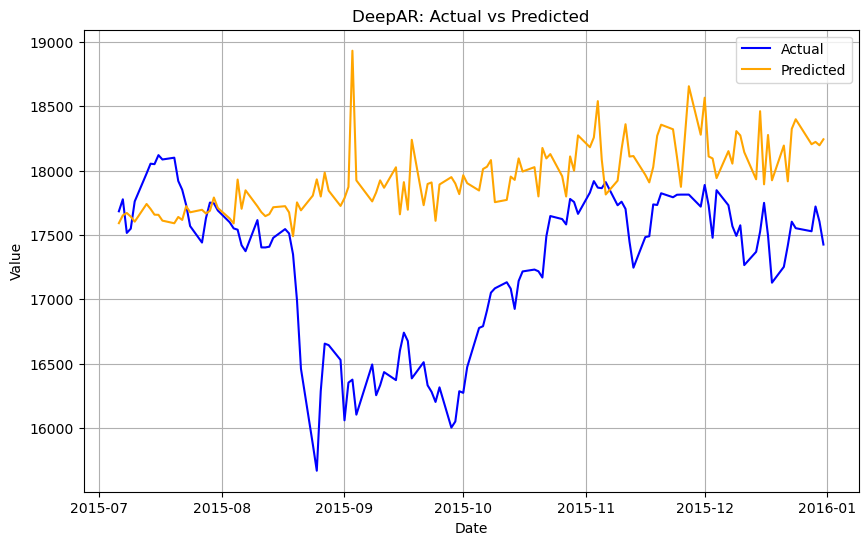

In [77]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.field_names import FieldName
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch

additive_features = [
    'ema_20', 'high_lag_1',
    'low_lag_1', 'open',
    'rsi_14', 'sma_20'
]
multiplicative_features = [
    'overall_avg_negative', 'overall_avg_positive', 'volume_lag_1'
]

all_features = additive_features + multiplicative_features

# Assuming X_train and y_train are defined
X_train_new = X_train.copy()
scaler = MinMaxScaler()
X_train_new[all_features] = scaler.fit_transform(X_train[all_features])

# Prepare data for GluonTS
def create_gluonts_dataset(df, target, features, start_date):
    return ListDataset(
        [{
            FieldName.START: start_date,
            FieldName.TARGET: df[target].values,
            FieldName.FEAT_DYNAMIC_REAL: df[features].values.T
        }],
        freq='D'  # Assuming daily data; adjust if needed
    )

# DataFrame with target and features
data_df = pd.DataFrame({
    'y': y_train.values,
    **{col: X_train_new[col].values for col in all_features}
}, index=y_train.index)

# Manually create 80-20 train-validation split
n_total = len(data_df)
n_train = n_total -126  # 80% for training
train_idx = range(n_train)
val_idx = range(n_train, n_total)

# Split data
train_fold = data_df.iloc[train_idx]
val_fold = data_df.iloc[val_idx]

# Scale features
scaler_fold = MinMaxScaler()
train_fold_scaled = train_fold.copy()
val_fold_scaled = val_fold.copy()
train_fold_scaled[all_features] = scaler_fold.fit_transform(train_fold[all_features])
val_fold_scaled[all_features] = scaler_fold.transform(val_fold[all_features])

# Create GluonTS datasets
train_ds = create_gluonts_dataset(train_fold_scaled, 'y', all_features, train_fold.index[0])
val_ds = create_gluonts_dataset(val_fold_scaled, 'y', all_features, val_fold.index[0])

# Initialize DeepAR model
# estimator = DeepAREstimator(
#     freq='D',  # Adjust frequency as needed
#     prediction_length=126,  # Predict length of validation set
#     context_length=30,  # Context length for training
#     num_layers=2,
#     dropout_rate=0.1,
#     trainer_kwargs={'max_epochs': 10}
# )
estimator = DeepAREstimator(
    freq='D',
    prediction_length=126,
    context_length=30,
    num_layers=8,
    hidden_size=160,
    dropout_rate=0.1,
    # num_feat_dynamic_real=len(all_features),
    # time_features=time_features,
    lags_seq=[1, 2, 3, 7, 14, 30],  
    # scaling=False,
    num_parallel_samples=100,
    trainer_kwargs={'max_epochs': 10}
)
# Train the model
predictor = estimator.train(training_data=train_ds)

# Make predictions
forecasts = list(predictor.predict(val_ds))
val_preds = forecasts[0].mean  # Take mean of probabilistic forecast

# Evaluate predictions
mse = mean_squared_error(val_fold['y'], val_preds)
r2 = r2_score(val_fold['y'], val_preds)
print(f"Validation MSE: {mse:.2f}, R²: {r2:.4f}")
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds, label='Predicted', color='orange')
plt.title('DeepAR: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig('deepar_forecast.png')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1824, 4], [1, 1824], [1, 1824], [1, 366, 4]] | [1, 100, 366]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 7.24526 (best 7.24526), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_13\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.22326 (best 6.22326), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_13\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.04198 (best 6.04198), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_13\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.93699 (best 5.93699), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_13\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 5.77539 (best 5.77539), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_13\\checkpoints\\epoch=4-step=250.ck

Validation MSE: 5414582.86, R²: -15.7772



  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1152, 4], [1, 1152], [1, 1152], [1, 126, 4]] | [1, 100, 126]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 9.85512 (best 9.85512), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_14\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.23049 (best 8.23049), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_14\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.03203 (best 8.03203), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_14\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.95149 (best 7.95149), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_14\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.61047 (best 7.61047), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_14\\checkpoints\\epoch=4-step=250.ck

Final model trained


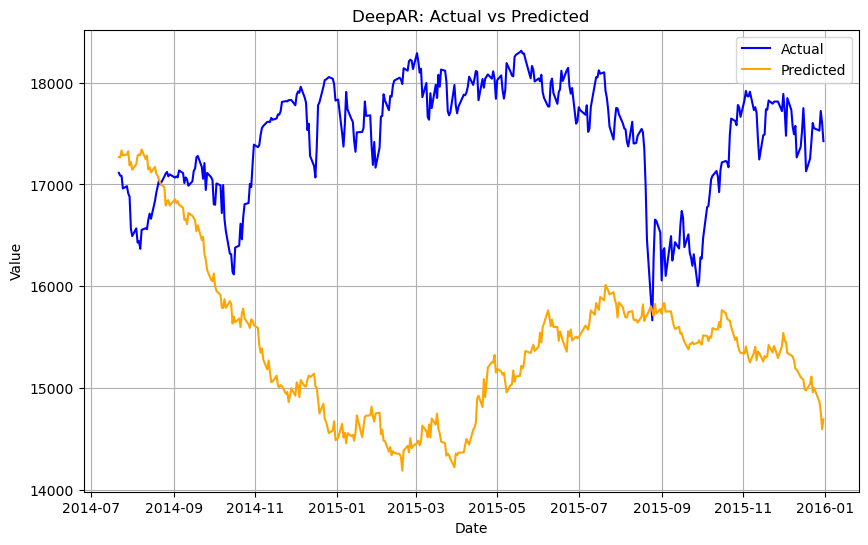

In [42]:

# Train the model
predictor = estimator.train(training_data=train_ds)

# Make predictions
forecasts = list(predictor.predict(val_ds))
val_preds = forecasts[0].mean  # Take mean of probabilistic forecast

# Evaluate predictions
mse = mean_squared_error(val_fold['y'], val_preds)
r2 = r2_score(val_fold['y'], val_preds)
print(f"Validation MSE: {mse:.2f}, R²: {r2:.4f}")

# Train final model on full training data
final_train_ds = create_gluonts_dataset(data_df, 'y', all_features, y_train.index[0])
final_estimator = DeepAREstimator(
    freq='D',
    prediction_length=126,  # As per original code
    context_length=60,
    num_layers=2,
    dropout_rate=0.1,
    trainer_kwargs={'max_epochs': 10}
)
final_predictor = final_estimator.train(training_data=final_train_ds)
print("Final model trained")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds, label='Predicted', color='orange')
plt.title('DeepAR: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig('deepar_forecast.png')

## 2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


X_test_scaled feature ranges:
           ema_20  high_lag_1   low_lag_1        open      rsi_14      sma_20  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.915493    0.911349    0.901934    0.907652    0.577678    0.917080   
std      0.052811    0.056999    0.061631    0.058780    0.188065    0.056189   
min      0.821553    0.789247    0.760900    0.777071    0.180331    0.814122   
25%      0.861823    0.855805    0.843670    0.848431    0.434709    0.864000   
50%      0.937654    0.938854    0.932053    0.932918    0.586920    0.940426   
75%      0.964250    0.958025    0.951496    0.954233    0.719141    0.965358   
max      0.971726    0.984218    0.979551    0.981117    0.902205    0.977974   

       overall_avg_negative  overall_avg_positive  volume_lag_1  
count            126.000000            126.000000    126.000000  
mean               0.576906              0.308881      0.156029  
std                0.130698              0


  | Name  | Type        | Params | Mode  | In sizes                                                    | Out sizes    
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.6 M  | train | [[1, 1], [1, 1], [1, 59, 4], [1, 59], [1, 59], [1, 126, 4]] | [1, 100, 126]
----------------------------------------------------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.220     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 9.08062 (best 9.08062), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_2\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.29145 (best 8.29145), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_2\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.17153 (best 8.17153), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_2\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.13522 (best 8.13522), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_2\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.12941 (best 8.12941), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_2\\checkpoints\\epoch=4-step=250.ckpt' a

Validation MSE: 5009602.13, R²: -13.2446


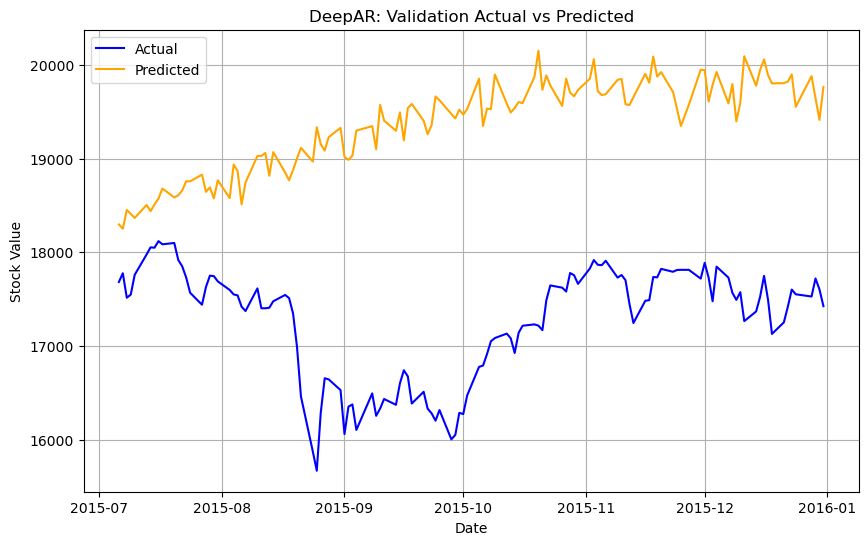

In [78]:
import pandas as pd
import numpy as np
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.field_names import FieldName
from gluonts.time_feature import time_features_from_frequency_str
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Feature lists
additive_features = [
    'ema_20', 'high_lag_1',
    'low_lag_1', 'open',
    'rsi_14', 'sma_20'
]
multiplicative_features = [
    'overall_avg_negative', 'overall_avg_positive', 'volume_lag_1'
]

all_features = additive_features + multiplicative_features

# Assuming X_train, y_train, and X_test are defined
# Prepare training data
X_train_new = X_train.copy()
scaler = MinMaxScaler()
X_train_new[all_features] = scaler.fit_transform(X_train[all_features])

# Check for NaNs in training features
if X_train_new[all_features].isna().any().any():
    raise ValueError("NaNs detected in X_train_new features")

# DataFrame with target and features
data_df = pd.DataFrame({
    'y': y_train.values,  # Unscaled target
    **{col: X_train_new[col].values for col in all_features}
}, index=y_train.index)

# Prepare test data
X_test_scaled = X_test.copy()

# Verify all features are in X_test
missing_features = [col for col in all_features if col not in X_test_scaled.columns]
if missing_features:
    raise ValueError(f"Missing features in X_test: {missing_features}")

# Apply scaling to test features
X_test_scaled[all_features] = scaler.transform(X_test[all_features])

# Check for NaNs in test features
if X_test_scaled[all_features].isna().any().any():
    raise ValueError("NaNs detected in X_test_scaled features")

# Debug: Print feature ranges for X_test_scaled
print("X_test_scaled feature ranges:")
print(X_test_scaled[all_features].describe())

# Prepare GluonTS datasets
def create_gluonts_dataset(df, target, features, start_date):
    return ListDataset(
        [{
            FieldName.START: start_date,
            FieldName.TARGET: df[target].values if target in df else [],
            FieldName.FEAT_DYNAMIC_REAL: df[features].values.T
        }],
        freq='D'  # Adjust if needed
    )

# Manually create 80-20 train-validation split
n_total = len(data_df)
n_train = n_total-126
train_idx = range(n_train)
val_idx = range(n_train, n_total)

# Split data
train_fold = data_df.iloc[train_idx]
val_fold = data_df.iloc[val_idx]

# Scale features for train and validation
scaler_fold = MinMaxScaler()
train_fold_scaled = train_fold.copy()
val_fold_scaled = val_fold.copy()
train_fold_scaled[all_features] = scaler_fold.fit_transform(train_fold[all_features])
val_fold_scaled[all_features] = scaler_fold.transform(val_fold[all_features])

# Create GluonTS datasets for train and validation
train_ds = create_gluonts_dataset(train_fold_scaled, 'y', all_features, train_fold.index[0])
val_ds = create_gluonts_dataset(val_fold_scaled, 'y', all_features, val_fold.index[0])

time_features = time_features_from_frequency_str('D')  # Daily frequency features

# Initialize DeepAR model
estimator = DeepAREstimator(
    freq='D',
    prediction_length=126,
    context_length=30,
    num_layers=8,
    hidden_size=160,
    dropout_rate=0.1,
    # num_feat_dynamic_real=len(all_features),
    time_features=time_features,
    lags_seq=[1, 2, 3, 7, 14, 30],  
    # scaling=False,
    num_parallel_samples=100,
    trainer_kwargs={'max_epochs': 30}
)

# Train the model
predictor = estimator.train(training_data=train_ds)

# Make validation predictions
forecasts = list(predictor.predict(val_ds))
val_preds = forecasts[0].mean

# Evaluate validation predictions
mse = mean_squared_error(val_fold['y'], val_preds)
r2 = r2_score(val_fold['y'], val_preds)
print(f"Validation MSE: {mse:.2f}, R²: {r2:.4f}")

# Visualize validation predictions
plt.figure(figsize=(10, 6))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds, label='Predicted', color='orange')
plt.title('DeepAR: Validation Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.legend()
plt.grid(True)
plt.savefig('deepar_forecast.png')


In [71]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[265.39066 , -43.182373,  66.02742 , ..., 206.66357 , 193.81195 ,
         303.54437 ],
        [107.43683 , 323.44153 , 272.28918 , ..., -17.628098,  30.01538 ,
         319.67917 ],
        [993.3291  , 248.04233 , 245.63416 , ..., 100.0292  , 205.16676 ,
         144.4993  ],
        ...,
        [241.6538  , 317.866   , -31.423325, ...,  66.1366  , 150.65318 ,
         318.43234 ],
        [-56.34375 , 195.5599  , 178.95103 , ..., 337.66003 ,  83.01306 ,
         365.31354 ],
        [252.1332  , 177.48318 , 283.8601  , ..., 325.37646 , 261.51364 ,
         182.01956 ]], dtype=float32), start_date=Period('2015-11-09', 'D'))]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                       | Out sizes    
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 1.6 M  | train | [[1, 1], [1, 1], [1, 155, 4], [1, 155], [1, 155], [1, 126, 4]] | [1, 100, 126]
-------------------------------------------------------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.220     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 9.14277 (best 9.14277), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_3\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.09216 (best 8.09216), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_3\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.04177 (best 8.04177), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_3\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.02934 (best 8.02934), saving model to 'd:\\course\\PTKD\\EDA-Business-Analytics\\lightning_logs\\version_3\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 8.01136 (best 8.01136), saving mode

Final model trained
Raw test predictions (first 10): [1.03065119e-10 1.03292160e-10 1.03305295e-10 1.03321698e-10
 1.03345180e-10 1.04108111e-10 1.03819356e-10 1.03144708e-10
 1.04003757e-10 1.03913260e-10]
Submission DataFrame (latest dates first):
     Id         Close
125   1  1.077360e-10
124   2  1.068735e-10
123   3  1.053015e-10
122   4  1.066058e-10
121   5  1.072376e-10
120   6  1.070089e-10
119   7  1.069554e-10
118   8  1.074805e-10
117   9  1.068775e-10
116  10  1.078134e-10


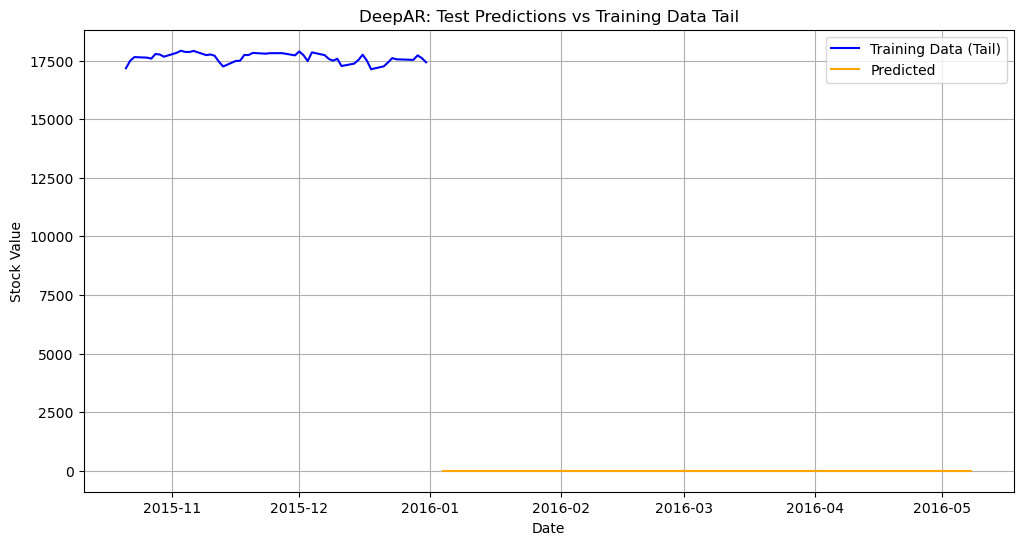

In [79]:

# Train final model on full training data
final_train_ds = create_gluonts_dataset(data_df, 'y', all_features, y_train.index[0])
final_estimator = DeepAREstimator(
    freq='D',
    prediction_length=126,
    context_length=126,
    num_layers=8,
    hidden_size=160,
    dropout_rate=0.1,
    # num_feat_dynamic_real=len(all_features),
    time_features=time_features,
    lags_seq=[1, 2, 3, 7, 14, 30],  
    # scaling=False,
    num_parallel_samples=100,
    trainer_kwargs={'max_epochs': 30}
)
final_predictor = final_estimator.train(training_data=final_train_ds)
print("Final model trained")

# Prepare test dataset with historical context
# Append last context_length points from training data to test data
context_length = 126
train_tail = data_df.iloc[-context_length:].copy()
test_combined = pd.concat([train_tail, X_test_scaled[all_features]], axis=0)
test_combined.index = pd.date_range(start=y_train.index[-context_length], periods=len(test_combined), freq='D')

# Create test dataset starting after training data
test_ds = create_gluonts_dataset(
    test_combined,
    'y',
    all_features,
    start_date=y_train.index[-context_length] + pd.Timedelta(days=1)
)

# Make test predictions
test_forecasts = list(final_predictor.predict(test_ds))
test_preds = test_forecasts[0].mean[-126:]  # Take last 126 predictions to match prediction_length

# Debug: Print raw test predictions
print("Raw test predictions (first 10):", test_preds[:10])

# Create date range for test predictions
test_dates = pd.date_range(start=X_test_scaled.index[0], periods=len(test_preds), freq='D')

# Create submission DataFrame
submission_df = pd.DataFrame({
    'ds': test_dates,
    'Close': test_preds  # No scaling, assuming model predicts in original scale
})

# Sort by date in descending order
submission_df = submission_df.sort_values(by='ds', ascending=False)

# Add Id column
submission_df['Id'] = range(1, len(submission_df) + 1)

# Select required columns
submission_df = submission_df[['Id', 'Close']]

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

# Display submission DataFrame
print("Submission DataFrame (latest dates first):")
print(submission_df.head(10))

# Visualize test predictions with training data tail
plt.figure(figsize=(12, 6))
train_tail = y_train[-50:] if len(y_train) >= 50 else y_train
train_tail_dates = y_train.index[-50:] if len(y_train) >= 50 else y_train.index
plt.plot(train_tail_dates, train_tail, label='Training Data (Tail)', color='blue')
plt.plot(test_dates, test_preds, label='Predicted', color='orange')
plt.title('DeepAR: Test Predictions vs Training Data Tail')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.legend()
plt.grid(True)
plt.savefig('deepar_test_forecast.png')

Validation MSE: 5881912.03, R²: -15.7250


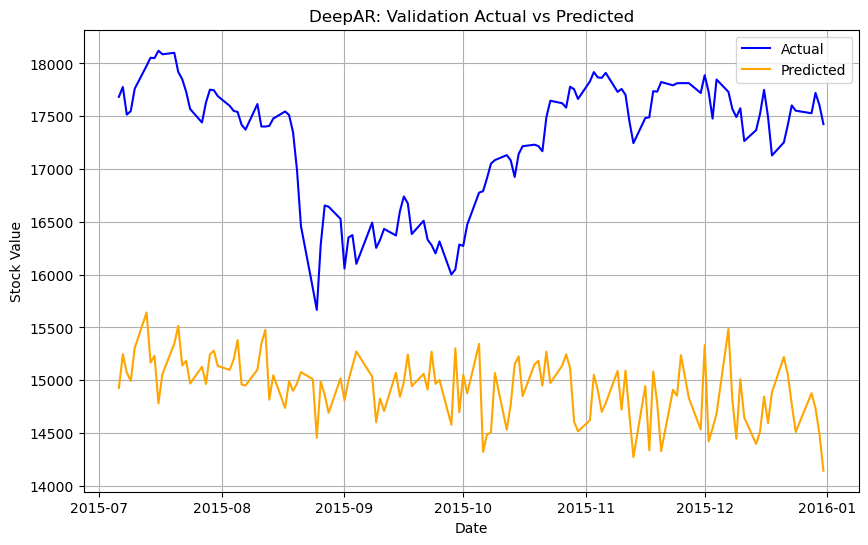

In [81]:
forecasts = list(final_predictor.predict(val_ds))
val_preds = forecasts[0].mean

# Evaluate validation predictions
mse = mean_squared_error(val_fold['y'], val_preds)
r2 = r2_score(val_fold['y'], val_preds)
print(f"Validation MSE: {mse:.2f}, R²: {r2:.4f}")

# Visualize validation predictions
plt.figure(figsize=(10, 6))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds, label='Predicted', color='orange')
plt.title('DeepAR: Validation Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.legend()
plt.grid(True)
plt.savefig('deepar_forecast.png')

# LSTM

Epoch 1/1000, Train Loss: 0.081337, Val Loss: 0.008985
Epoch 2/1000, Train Loss: 0.004702, Val Loss: 0.004841
Epoch 3/1000, Train Loss: 0.002631, Val Loss: 0.004947
Epoch 4/1000, Train Loss: 0.002682, Val Loss: 0.004605
Epoch 5/1000, Train Loss: 0.002578, Val Loss: 0.005023
Epoch 6/1000, Train Loss: 0.002616, Val Loss: 0.004680
Epoch 7/1000, Train Loss: 0.002481, Val Loss: 0.005015
Epoch 8/1000, Train Loss: 0.002402, Val Loss: 0.005313
Epoch 9/1000, Train Loss: 0.002508, Val Loss: 0.004480
Epoch 10/1000, Train Loss: 0.002422, Val Loss: 0.004435
Epoch 11/1000, Train Loss: 0.002425, Val Loss: 0.004853
Epoch 12/1000, Train Loss: 0.002378, Val Loss: 0.004974
Epoch 13/1000, Train Loss: 0.002320, Val Loss: 0.004486
Epoch 14/1000, Train Loss: 0.002247, Val Loss: 0.004524
Epoch 15/1000, Train Loss: 0.002343, Val Loss: 0.004488
Epoch 16/1000, Train Loss: 0.002577, Val Loss: 0.005500
Epoch 17/1000, Train Loss: 0.002294, Val Loss: 0.004227
Epoch 18/1000, Train Loss: 0.002216, Val Loss: 0.003992
E

(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

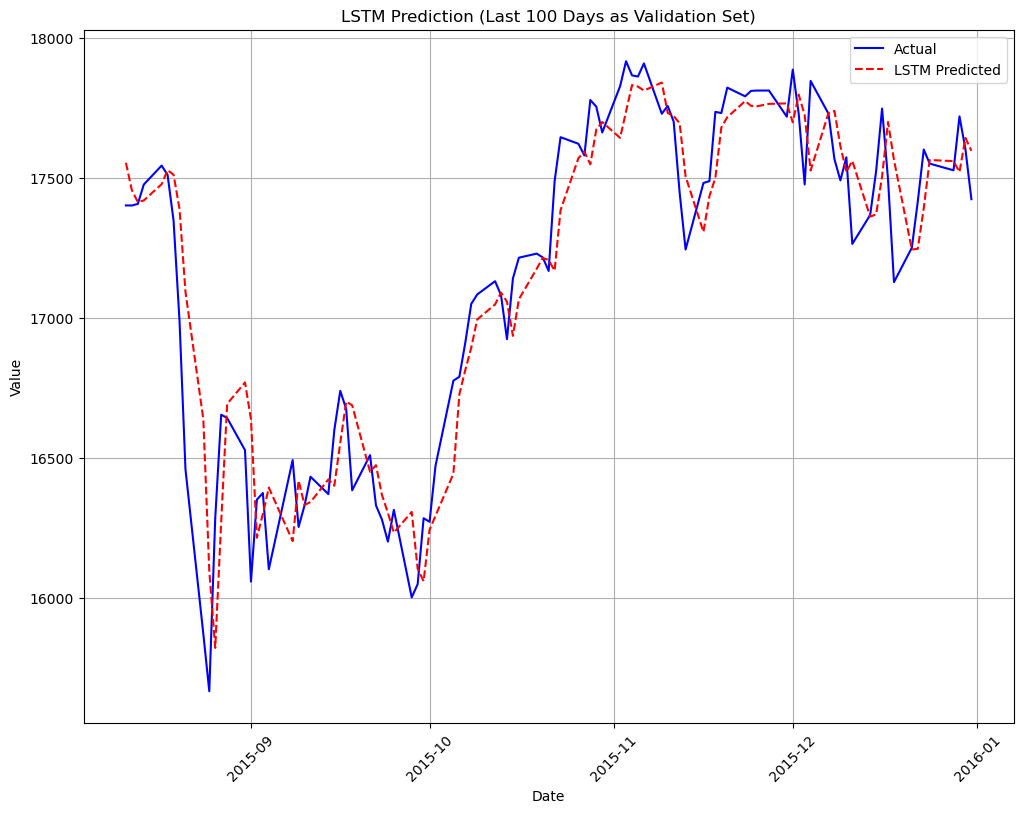

In [164]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from copy import deepcopy

# Feature lists
additive_features = [
    # 'ema_20', 
    'high_lag_1', 'high_lag_2', 
    'low_lag_1', 'low_lag_2',
    'open', 'open_lag_1', 

    # 'macd',
    # 'bb_lower', 
    # 'bb_upper', 
    # 'rsi_14', 
    # 'sma_20'
]
multiplicative_features = [
    # 'month_sin',
    # 'overall_avg_negative', 'overall_avg_positive'
]
all_features = additive_features + multiplicative_features
X_train_new = X_train.copy()
# X_train_new['momentum'] = X_train_new['open'] - X_train_new['open_lag_1']
# all_features += ['momentum']
# Function to create sequences for LSTM
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Define LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out

# Prepare data
prophet_df = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})
for col in all_features:
    prophet_df[col] = X_train_new[col].values

# Split into train and validation (last 126 days for validation)
val_days = 100
seq_length = 30

train_fold = prophet_df.iloc[:-val_days]
val_fold = prophet_df.iloc[-val_days - seq_length:]

# Scale features and target with RobustScaler
scaler_features = RobustScaler()
scaler_target = RobustScaler()
train_fold_scaled = train_fold.copy()
val_fold_scaled = val_fold.copy()
train_fold_scaled[all_features] = scaler_features.fit_transform(train_fold[all_features])
val_fold_scaled[all_features] = scaler_features.transform(val_fold[all_features])
train_fold_scaled['y'] = scaler_target.fit_transform(train_fold[['y']])
val_fold_scaled['y'] = scaler_target.transform(val_fold[['y']])

# Create sequences for LSTM
X_train_seq, y_train_seq = create_sequences(
    train_fold_scaled[all_features + ['y']].values,
    train_fold_scaled['y'].values,
    seq_length
)
X_val_seq, y_val_seq = create_sequences(
    val_fold_scaled[all_features + ['y']].values,
    val_fold_scaled['y'].values,
    seq_length
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).reshape(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMModel(input_size=len(all_features) + 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop with early stopping
num_epochs = 1000
best_val_loss = float('inf')
patience = 50
counter = 0
best_model_state = None

for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(lstm_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")


# Load best model
lstm_model.load_state_dict(best_model_state)

# Evaluate on validation set
lstm_model.eval()
with torch.no_grad():
    val_preds_scaled = lstm_model(X_val_tensor.to(device)).cpu().numpy()
val_preds = scaler_target.inverse_transform(val_preds_scaled)
final_val['lstm'] = val_preds.reshape(-1)
y_val_actual = scaler_target.inverse_transform(y_val_seq.reshape(-1, 1))

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open'].iloc[seq_length:].values
y_val_actual_heuristic = val_fold['y'].iloc[seq_length:].values

# Compute metrics for LSTM
mse_lstm = mean_squared_error(y_val_actual, val_preds)
r2_lstm = r2_score(y_val_actual, val_preds)
print(f"LSTM Validation MSE: {mse_lstm:.2f}")
print(f"LSTM Validation R²: {r2_lstm:.4f}")

# Compute metrics for heuristic
mse_heuristic = mean_squared_error(y_val_actual_heuristic, val_preds_heuristic)
r2_heuristic = r2_score(y_val_actual_heuristic, val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")


# Plot actual vs predicted values for validation set
plt.figure(figsize=(12, 9))
plt.plot(val_fold_scaled['ds'].iloc[seq_length:], y_val_actual, label='Actual', color='blue')
plt.plot(val_fold_scaled['ds'].iloc[seq_length:], val_preds, label='LSTM Predicted', color='red', linestyle='--')
# plt.plot(val_fold_scaled['ds'].iloc[seq_length:], val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('LSTM Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()


## Test set inference

[FULL] Epoch 1/1000, Train Loss: 0.094704
[FULL] Epoch 2/1000, Train Loss: 0.005463
[FULL] Epoch 3/1000, Train Loss: 0.002829
[FULL] Epoch 4/1000, Train Loss: 0.002663
[FULL] Epoch 5/1000, Train Loss: 0.002597
[FULL] Epoch 6/1000, Train Loss: 0.002715
[FULL] Epoch 7/1000, Train Loss: 0.002886
[FULL] Epoch 8/1000, Train Loss: 0.002804
[FULL] Epoch 9/1000, Train Loss: 0.002490
[FULL] Epoch 10/1000, Train Loss: 0.002400
[FULL] Epoch 11/1000, Train Loss: 0.002402
[FULL] Epoch 12/1000, Train Loss: 0.002511
[FULL] Epoch 13/1000, Train Loss: 0.002462
[FULL] Epoch 14/1000, Train Loss: 0.002385
[FULL] Epoch 15/1000, Train Loss: 0.002407
[FULL] Epoch 16/1000, Train Loss: 0.002389
[FULL] Epoch 17/1000, Train Loss: 0.002313
[FULL] Epoch 18/1000, Train Loss: 0.002313
[FULL] Epoch 19/1000, Train Loss: 0.002263
[FULL] Epoch 20/1000, Train Loss: 0.002302
[FULL] Epoch 21/1000, Train Loss: 0.002113
[FULL] Epoch 22/1000, Train Loss: 0.002530
[FULL] Epoch 23/1000, Train Loss: 0.002158
[FULL] Epoch 24/1000

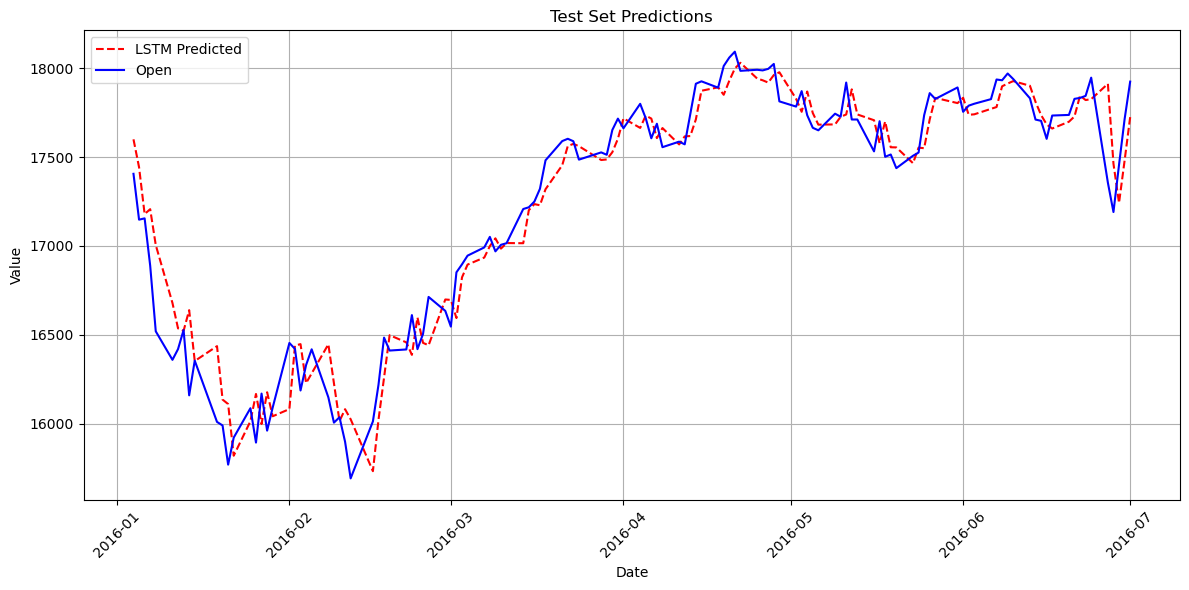

In [176]:
# ...existing code...

# === Retrain LSTM on full training set and predict on test set ===

# 1. Prepare full training and test DataFrames
X_train_new = X_train.copy()
X_test_new = X_test.copy()

prophet_df_full = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})
for col in all_features:
    prophet_df_full[col] = X_train_new[col].values

prophet_test_df = pd.DataFrame({
    'ds': X_test.index
})
for col in all_features:
    prophet_test_df[col] = X_test_new[col].values

# 2. Scale features and target using only training data
scaler_features = RobustScaler()
scaler_target = RobustScaler()
prophet_df_full_scaled = prophet_df_full.copy()
prophet_test_df_scaled = prophet_test_df.copy()
prophet_df_full_scaled[all_features] = scaler_features.fit_transform(prophet_df_full[all_features])
prophet_test_df_scaled[all_features] = scaler_features.transform(prophet_test_df[all_features])
prophet_df_full_scaled['y'] = scaler_target.fit_transform(prophet_df_full[['y']])

# 3. Create sequences for LSTM (features only, no 'y' in input)
seq_length = 30
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X_full_seq, y_full_seq = create_sequences(
    prophet_df_full_scaled[all_features].values,
    prophet_df_full_scaled['y'].values,
    seq_length
)

# For test, use last seq_length rows from train, then roll through test
test_concat = pd.concat([
    prophet_df_full_scaled[all_features].iloc[-seq_length:],
    prophet_test_df_scaled[all_features]
], ignore_index=True)
X_test_seq = []
for i in range(len(X_test)):
    X_test_seq.append(test_concat.iloc[i:i+seq_length].values)
X_test_seq = np.array(X_test_seq)

# 4. Convert to PyTorch tensors and DataLoader
X_full_tensor = torch.tensor(X_full_seq, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full_seq, dtype=torch.float32).reshape(-1, 1)
full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# 5. Initialize and train LSTM on full data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_final_model = LSTMModel(input_size=len(all_features)).to(device)  # <-- FIXED input_size
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_final_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

num_epochs = 1000
best_loss = float('inf')
patience = 50
counter = 0
best_model_state = None

for epoch in range(num_epochs):
    lstm_final_model.train()
    train_loss = 0
    for X_batch, y_batch in full_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = lstm_final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(full_loader)
    scheduler.step(train_loss)
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_state = deepcopy(lstm_final_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"[FULL] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")

# Load best model
lstm_final_model.load_state_dict(best_model_state)

# 6. Predict on test set
lstm_final_model.eval()
with torch.no_grad():
    test_preds_scaled = lstm_final_model(X_test_tensor.to(device)).cpu().numpy()
test_preds = scaler_target.inverse_transform(test_preds_scaled)

# 7. Prepare submission DataFrame
lstm_submission_df = pd.DataFrame({
    'ds': X_test.index,
    'Close': test_preds.reshape(-1) * 1e5  # scale if needed
})
lstm_submission_df = lstm_submission_df.sort_values(by='ds', ascending=False)
lstm_submission_df['Id'] = range(1, len(lstm_submission_df) + 1)
lstm_submission_df = lstm_submission_df[['Id', 'Close']]
lstm_submission_df.to_csv('lstm_submission.csv', index=False)
print("\nSubmission file 'lstm_submission.csv' has been created.")

# 8. Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, test_preds, label='LSTM Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# ...existing code...

In [174]:
X_full_seq

array([[[-0.35805417, -0.31917703, -0.36543808, ..., -0.36688294,
         -0.36265158, -0.33332682],
        [-0.32198964, -0.35776671, -0.35222934, ..., -0.33234312,
         -0.36676873, -0.31156014],
        [-0.31500824, -0.32169558, -0.34470935, ..., -0.31063671,
         -0.33219667, -0.45137565],
        ...,
        [-0.62281107, -0.65632594, -0.65939403, ..., -0.63711127,
         -0.66372758, -0.63936295],
        [-0.63068002, -0.62257214, -0.63488282, ..., -0.63749838,
         -0.6372494 , -0.58444744],
        [-0.58696212, -0.63044253, -0.62257882, ..., -0.58480572,
         -0.63763687, -0.67182511]],

       [[-0.32198964, -0.35776671, -0.35222934, ..., -0.33234312,
         -0.36676873, -0.31156014],
        [-0.31500824, -0.32169558, -0.34470935, ..., -0.31063671,
         -0.33219667, -0.45137565],
        [-0.3200588 , -0.3147129 , -0.43524492, ..., -0.44889668,
         -0.31046998, -0.36414195],
        ...,
        [-0.63068002, -0.62257214, -0.63488282, ..., -

# GRU

Epoch 1/1000, Train Loss: 0.094521, Val Loss: 0.004268
Epoch 2/1000, Train Loss: 0.002848, Val Loss: 0.003697
Epoch 3/1000, Train Loss: 0.002715, Val Loss: 0.003591
Epoch 4/1000, Train Loss: 0.002639, Val Loss: 0.004078
Epoch 5/1000, Train Loss: 0.002632, Val Loss: 0.003523
Epoch 6/1000, Train Loss: 0.002350, Val Loss: 0.003587
Epoch 7/1000, Train Loss: 0.002283, Val Loss: 0.003570
Epoch 8/1000, Train Loss: 0.002201, Val Loss: 0.003354
Epoch 9/1000, Train Loss: 0.002226, Val Loss: 0.003318
Epoch 10/1000, Train Loss: 0.001948, Val Loss: 0.003488
Epoch 11/1000, Train Loss: 0.002108, Val Loss: 0.003267
Epoch 12/1000, Train Loss: 0.002076, Val Loss: 0.003240
Epoch 13/1000, Train Loss: 0.002031, Val Loss: 0.003198
Epoch 14/1000, Train Loss: 0.002074, Val Loss: 0.003189
Epoch 15/1000, Train Loss: 0.001994, Val Loss: 0.003120
Epoch 16/1000, Train Loss: 0.001974, Val Loss: 0.003579
Epoch 17/1000, Train Loss: 0.001952, Val Loss: 0.003066
Epoch 18/1000, Train Loss: 0.001777, Val Loss: 0.003047
E

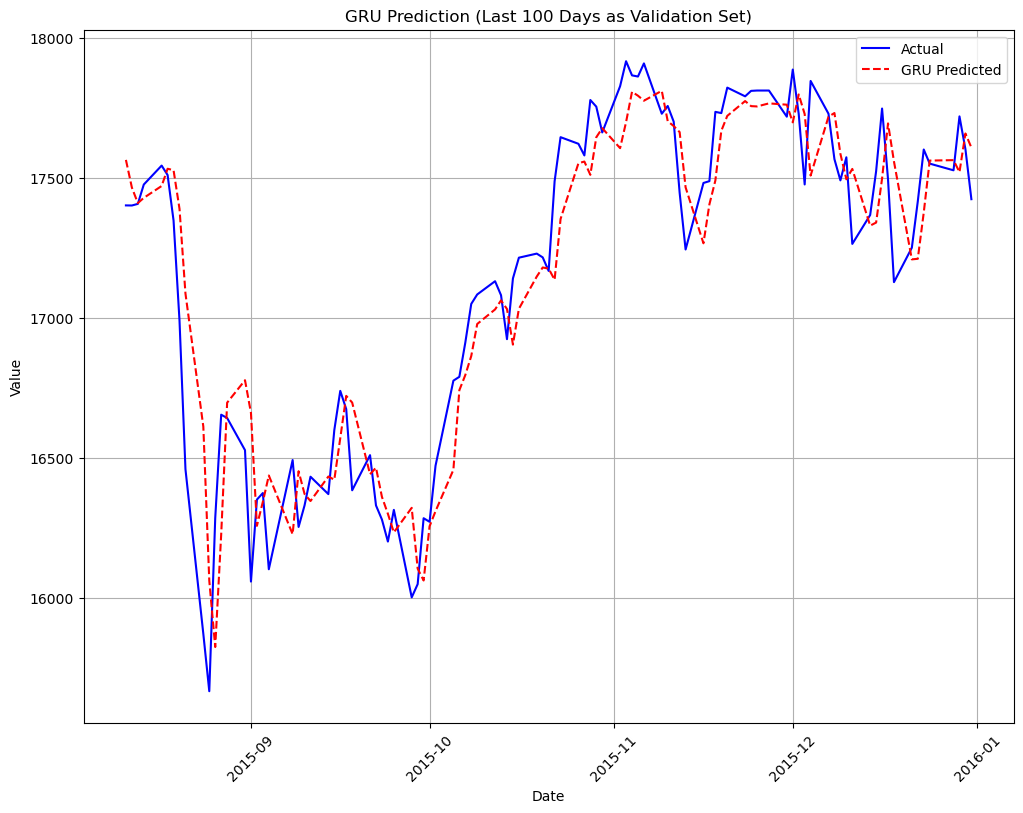

In [165]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from copy import deepcopy

additive_features = [
    # 'ema_20', 
    'high_lag_1', 
    'low_lag_1', 
    'open', 
    # 'open_lag_1', 
    # 'macd',
    # 'bb_lower', 
    # 'bb_upper', 
    # 'rsi_14', 
    # 'sma_20'
]
multiplicative_features = [
    # 'month_sin',
    # 'overall_avg_negative', 'overall_avg_positive'
]
all_features = additive_features + multiplicative_features
X_train_new = X_train.copy()

# Function to create sequences for GRU (unchanged)
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Define GRU model in PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, dropout=0.1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out

# Prepare data (unchanged)
prophet_df = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})
for col in all_features:
    prophet_df[col] = X_train_new[col].values

# Split into train and validation (last 100 days for validation)
val_days = 100
seq_length = 30

train_fold = prophet_df.iloc[:-val_days]
val_fold = prophet_df.iloc[-val_days - seq_length:]

# Scale features and target with RobustScaler (unchanged)
scaler_features = RobustScaler()
scaler_target = RobustScaler()
train_fold_scaled = train_fold.copy()
val_fold_scaled = val_fold.copy()
train_fold_scaled[all_features] = scaler_features.fit_transform(train_fold[all_features])
val_fold_scaled[all_features] = scaler_features.transform(val_fold[all_features])
train_fold_scaled['y'] = scaler_target.fit_transform(train_fold[['y']])
val_fold_scaled['y'] = scaler_target.transform(val_fold[['y']])

# Create sequences for GRU (unchanged)
X_train_seq, y_train_seq = create_sequences(
    train_fold_scaled[all_features + ['y']].values,
    train_fold_scaled['y'].values,
    seq_length
)
X_val_seq, y_val_seq = create_sequences(
    val_fold_scaled[all_features + ['y']].values,
    val_fold_scaled['y'].values,
    seq_length
)

# Convert to PyTorch tensors (unchanged)
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).reshape(-1, 1)

# Create DataLoaders (unchanged)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUModel(input_size=len(all_features) + 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop with early stopping (unchanged)
num_epochs = 1000
best_val_loss = float('inf')
patience = 50
counter = 0
best_model_state = None

for epoch in range(num_epochs):
    gru_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    gru_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = gru_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(gru_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

# Load best model
gru_model.load_state_dict(best_model_state)

# Evaluate on validation set
gru_model.eval()
with torch.no_grad():
    val_preds_scaled = gru_model(X_val_tensor.to(device)).cpu().numpy()
val_preds = scaler_target.inverse_transform(val_preds_scaled)
final_val['gru'] = val_preds
y_val_actual = scaler_target.inverse_transform(y_val_seq.reshape(-1, 1))

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open'].iloc[seq_length:].values
y_val_actual_heuristic = val_fold['y'].iloc[seq_length:].values

# Compute metrics for GRU
mse_gru = mean_squared_error(y_val_actual, val_preds)
r2_gru = r2_score(y_val_actual, val_preds)
print(f"GRU Validation MSE: {mse_gru:.2f}")
print(f"GRU Validation R²: {r2_gru:.4f}")

# Compute metrics for heuristic
mse_heuristic = mean_squared_error(y_val_actual_heuristic, val_preds_heuristic)
r2_heuristic = r2_score(y_val_actual_heuristic, val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Plot actual vs predicted values for validation set
plt.figure(figsize=(12, 9))
plt.plot(val_fold_scaled['ds'].iloc[seq_length:], y_val_actual, label='Actual', color='blue')
plt.plot(val_fold_scaled['ds'].iloc[seq_length:], val_preds, label='GRU Predicted', color='red', linestyle='--')
# plt.plot(val_fold_scaled['ds'].iloc[seq_length:], val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('GRU Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

## Test set inference

[FULL] Epoch 1/1000, Train Loss: 0.047634
[FULL] Epoch 2/1000, Train Loss: 0.002789
[FULL] Epoch 3/1000, Train Loss: 0.002594
[FULL] Epoch 4/1000, Train Loss: 0.002394
[FULL] Epoch 5/1000, Train Loss: 0.002395
[FULL] Epoch 6/1000, Train Loss: 0.002524
[FULL] Epoch 7/1000, Train Loss: 0.002368
[FULL] Epoch 8/1000, Train Loss: 0.002279
[FULL] Epoch 9/1000, Train Loss: 0.002166
[FULL] Epoch 10/1000, Train Loss: 0.002138
[FULL] Epoch 11/1000, Train Loss: 0.002188
[FULL] Epoch 12/1000, Train Loss: 0.002162
[FULL] Epoch 13/1000, Train Loss: 0.002228
[FULL] Epoch 14/1000, Train Loss: 0.002121
[FULL] Epoch 15/1000, Train Loss: 0.002162
[FULL] Epoch 16/1000, Train Loss: 0.002009
[FULL] Epoch 17/1000, Train Loss: 0.001993
[FULL] Epoch 18/1000, Train Loss: 0.002075
[FULL] Epoch 19/1000, Train Loss: 0.001962
[FULL] Epoch 20/1000, Train Loss: 0.001927
[FULL] Epoch 21/1000, Train Loss: 0.001908
[FULL] Epoch 22/1000, Train Loss: 0.002005
[FULL] Epoch 23/1000, Train Loss: 0.002061
[FULL] Epoch 24/1000

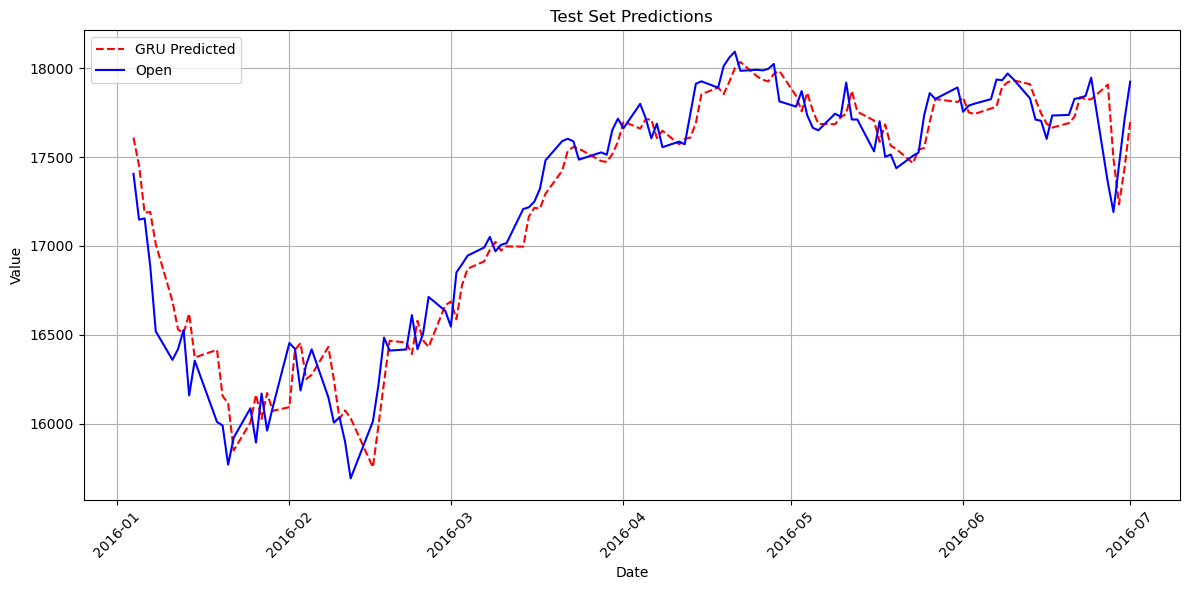

In [178]:
# ...existing code...

# === Retrain GRU on full training set and predict on test set ===

# 1. Prepare full training and test DataFrames
X_train_new = X_train.copy()
X_test_new = X_test.copy()

prophet_df_full = pd.DataFrame({
    'ds': y_train.index,
    'y': y_train.values
})
for col in all_features:
    prophet_df_full[col] = X_train_new[col].values

prophet_test_df = pd.DataFrame({
    'ds': X_test.index
})
for col in all_features:
    prophet_test_df[col] = X_test_new[col].values

# 2. Scale features and target using only training data
scaler_features = RobustScaler()
scaler_target = RobustScaler()
prophet_df_full_scaled = prophet_df_full.copy()
prophet_test_df_scaled = prophet_test_df.copy()
prophet_df_full_scaled[all_features] = scaler_features.fit_transform(prophet_df_full[all_features])
prophet_test_df_scaled[all_features] = scaler_features.transform(prophet_test_df[all_features])
prophet_df_full_scaled['y'] = scaler_target.fit_transform(prophet_df_full[['y']])

# 3. Create sequences for GRU (features only, no 'y' in input)
seq_length = 30
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X_full_seq, y_full_seq = create_sequences(
    prophet_df_full_scaled[all_features].values,
    prophet_df_full_scaled['y'].values,
    seq_length
)

# For test, use last seq_length rows from train, then roll through test
test_concat = pd.concat([
    prophet_df_full_scaled[all_features].iloc[-seq_length:],
    prophet_test_df_scaled[all_features]
], ignore_index=True)
X_test_seq = []
for i in range(len(X_test)):
    X_test_seq.append(test_concat.iloc[i:i+seq_length].values)
X_test_seq = np.array(X_test_seq)

# 4. Convert to PyTorch tensors and DataLoader
X_full_tensor = torch.tensor(X_full_seq, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full_seq, dtype=torch.float32).reshape(-1, 1)
full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# 5. Initialize and train GRU on full data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_final_model = GRUModel(input_size=len(all_features)).to(device)  # <-- FIXED input_size
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_final_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

num_epochs = 1000
best_loss = float('inf')
patience = 50
counter = 0
best_model_state = None

for epoch in range(num_epochs):
    gru_final_model.train()
    train_loss = 0
    for X_batch, y_batch in full_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = gru_final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(full_loader)
    scheduler.step(train_loss)
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_state = deepcopy(gru_final_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"[FULL] Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")

# Load best model
gru_final_model.load_state_dict(best_model_state)

# 6. Predict on test set
gru_final_model.eval()
with torch.no_grad():
    test_preds_scaled = gru_final_model(X_test_tensor.to(device)).cpu().numpy()
test_preds = scaler_target.inverse_transform(test_preds_scaled)

# 7. Prepare submission DataFrame
gru_submission_df = pd.DataFrame({
    'ds': X_test.index,
    'Close': test_preds.reshape(-1) * 1e5  # scale if needed
})
gru_submission_df = gru_submission_df.sort_values(by='ds', ascending=False)
gru_submission_df['Id'] = range(1, len(gru_submission_df) + 1)
gru_submission_df = gru_submission_df[['Id', 'Close']]
gru_submission_df.to_csv('gru_submission.csv', index=False)
print("\nSubmission file 'gru_submission.csv' has been created.")

# 8. Plot test predictions (and actuals if available)
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, test_preds, label='GRU Predicted', color='red', linestyle='--')
plt.plot(X_test.index, X_test['open'], label='Open', color='blue')
plt.title('Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('gru_test_predictions.png')
# ...existing code...

# ARIMA

ARIMA Validation MSE: 556526.19
ARIMA Validation R²: -0.5484
Heuristic (Open Price) Validation MSE: 38781.59
Heuristic (Open Price) Validation R²: 0.8921

Model Comparison:
Heuristic (open price) has lower or equal MSE than ARIMA.
Heuristic (open price) has higher or equal R² than ARIMA.


(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

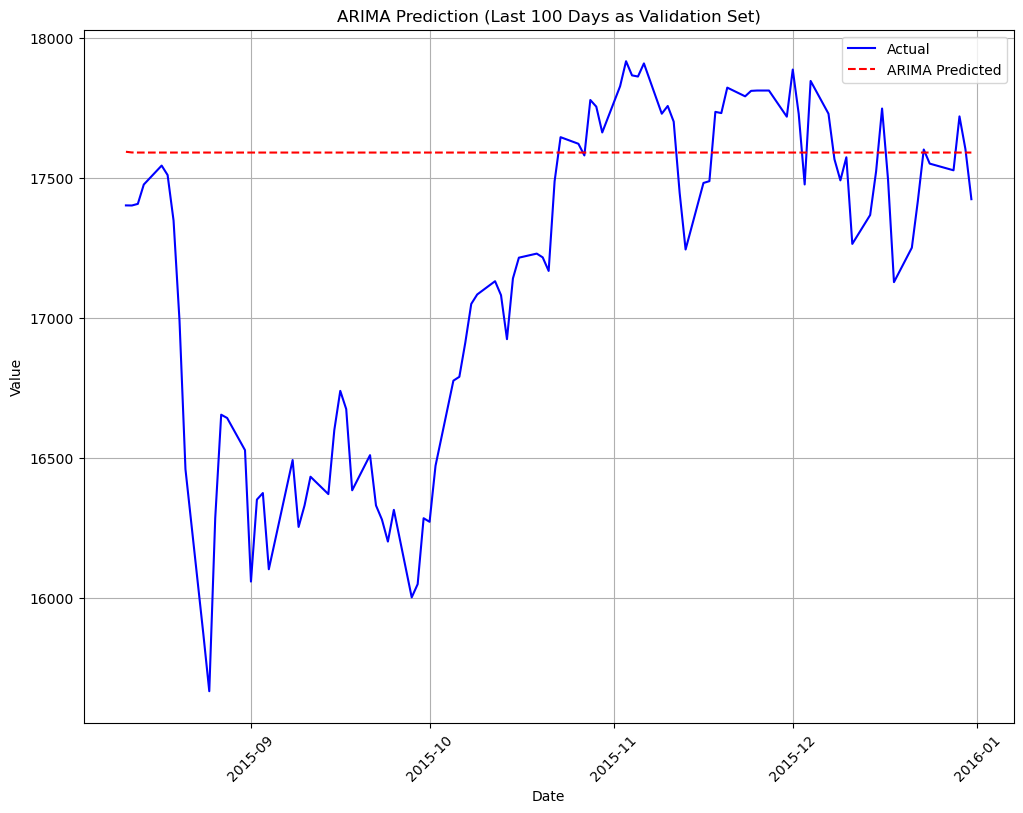

In [160]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Feature list (only 'open' is needed for heuristic)
heuristic_features = ['open']

# Assuming X_train, y_train are provided
# Prepare data for ARIMA (univariate, using y_train for close prices)
train_data = pd.DataFrame({
    'y': y_train.values,
    'open': X_train['open'].values
}, index=y_train.index)

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Fit ARIMA model on training data (close prices)
# Using ARIMA(1,1,1) as a starting point; adjust (p,d,q) based on ACF/PACF or domain knowledge
model = ARIMA(train_fold['y'], order=(1, 1, 1))
arima_result = model.fit()

# Make predictions on validation set
# Forecast for the length of the validation set
val_preds_arima = arima_result.forecast(steps=len(val_fold))

# Evaluate ARIMA predictions
mse_arima = mean_squared_error(val_fold['y'], val_preds_arima)
r2_arima = r2_score(val_fold['y'], val_preds_arima)
print(f"ARIMA Validation MSE: {mse_arima:.2f}")
print(f"ARIMA Validation R²: {r2_arima:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Compare models
print("\nModel Comparison:")
if mse_arima < mse_heuristic:
    print("ARIMA has lower MSE than the heuristic.")
else:
    print("Heuristic (open price) has lower or equal MSE than ARIMA.")
if r2_arima > r2_heuristic:
    print("ARIMA has higher R² than the heuristic.")
else:
    print("Heuristic (open price) has higher or equal R² than ARIMA.")

# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_arima, label='ARIMA Predicted', color='red', linestyle='--')
# plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('ARIMA Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Save the plot
# plt.savefig('arima_validation_predictions.png')

## SARIMA

SARIMA Validation MSE: 743717.65
SARIMA Validation R²: -1.0692
Heuristic (Open Price) Validation MSE: 38781.59
Heuristic (Open Price) Validation R²: 0.8921

Model Comparison:
Heuristic (open price) has lower or equal MSE than SARIMA.
Heuristic (open price) has higher or equal R² than SARIMA.


(array([16679., 16709., 16740., 16770., 16801.]),
 [Text(16679.0, 0, '2015-09'),
  Text(16709.0, 0, '2015-10'),
  Text(16740.0, 0, '2015-11'),
  Text(16770.0, 0, '2015-12'),
  Text(16801.0, 0, '2016-01')])

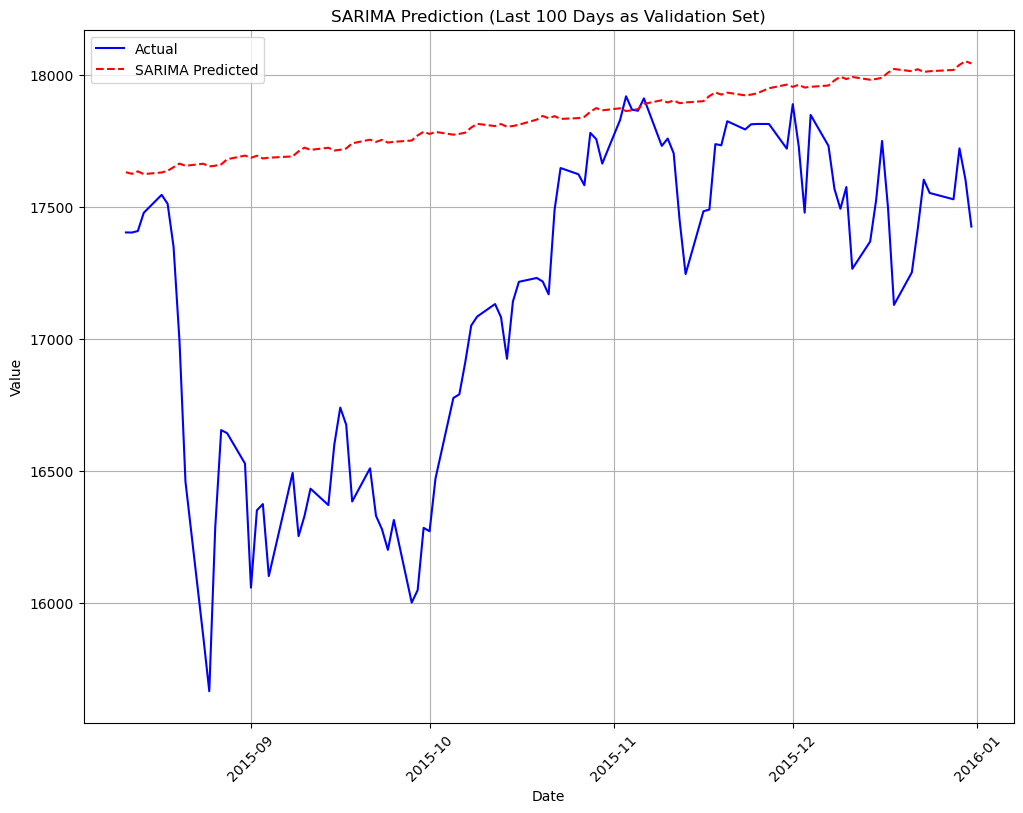

In [161]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Feature list (only 'open' is needed for heuristic)
heuristic_features = ['open']

# Assuming X_train, y_train are provided
# Prepare data for SARIMA (univariate, using y_train for close prices)
train_data = pd.DataFrame({
    'y': y_train.values,
    'open': X_train['open'].values
}, index=y_train.index)

# Split into train and validation (last 126 days for validation)
val_days = 100
train_fold = train_data.iloc[:-val_days]
val_fold = train_data.iloc[-val_days:]

# Fit SARIMA model on training data (close prices)
# Using SARIMA(1,1,1)(1,1,1,7) assuming weekly seasonality for daily data
model = SARIMAX(train_fold['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = model.fit(disp=False)

# Make predictions on validation set
# Forecast for the length of the validation set
val_preds_sarima = sarima_result.forecast(steps=len(val_fold))

# Evaluate SARIMA predictions
mse_sarima = mean_squared_error(val_fold['y'], val_preds_sarima)
r2_sarima = r2_score(val_fold['y'], val_preds_sarima)
print(f"SARIMA Validation MSE: {mse_sarima:.2f}")
print(f"SARIMA Validation R²: {r2_sarima:.4f}")

# Heuristic: Use open price as predicted close price
val_preds_heuristic = val_fold['open']
mse_heuristic = mean_squared_error(val_fold['y'], val_preds_heuristic)
r2_heuristic = r2_score(val_fold['y'], val_preds_heuristic)
print(f"Heuristic (Open Price) Validation MSE: {mse_heuristic:.2f}")
print(f"Heuristic (Open Price) Validation R²: {r2_heuristic:.4f}")

# Compare models
print("\nModel Comparison:")
if mse_sarima < mse_heuristic:
    print("SARIMA has lower MSE than the heuristic.")
else:
    print("Heuristic (open price) has lower or equal MSE than SARIMA.")
if r2_sarima > r2_heuristic:
    print("SARIMA has higher R² than the heuristic.")
else:
    print("Heuristic (open price) has higher or equal R² than SARIMA.")

# Plot actual vs predicted values
plt.figure(figsize=(12, 9))
plt.plot(val_fold.index, val_fold['y'], label='Actual', color='blue')
plt.plot(val_fold.index, val_preds_sarima, label='SARIMA Predicted', color='red', linestyle='--')
# plt.plot(val_fold.index, val_preds_heuristic, label='Heuristic (Open Price)', color='green', linestyle='-.')
plt.title('SARIMA Prediction (Last 100 Days as Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

# Save the plot
# plt.savefig('sarima_validation_predictions.png')

# Stacking Ensemble

Stacking Ensemble RMSE (Validation, last 30 days): 28118.4627
Stacking Ensemble R² Score (Validation, last 30 days): 0.2425

Feature Importance:
         Feature  Importance
0        prophet         155
2        xgboost         142
4           lstm          91
3  random_forest          65
1       lightgbm          63
5            gru          13


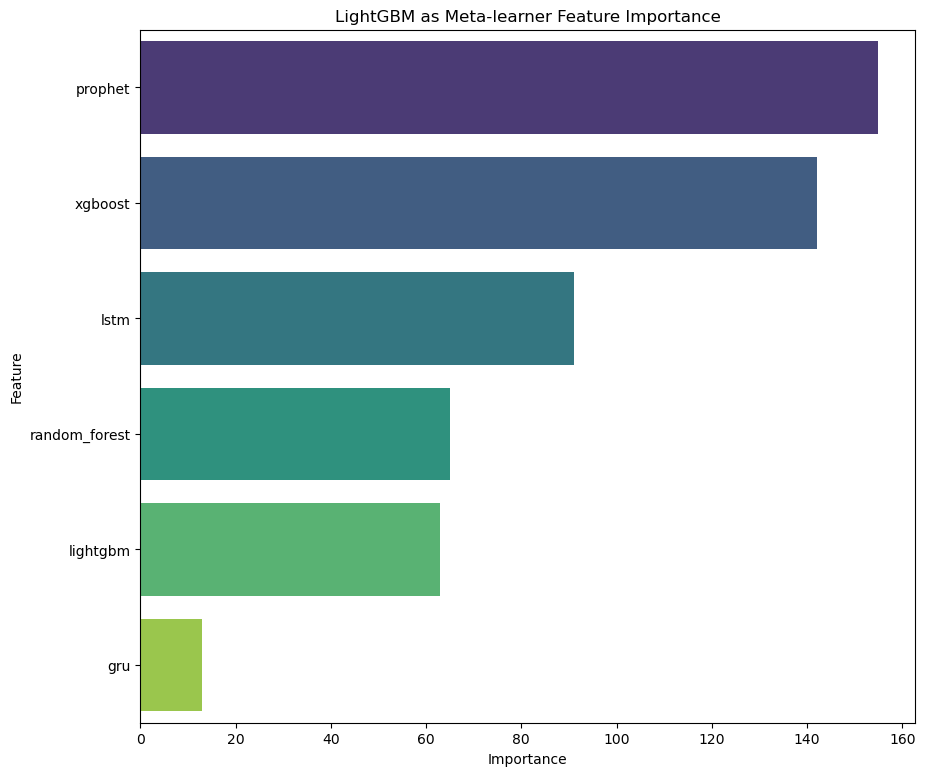

(array([1795., 1800., 1805., 1810., 1815., 1820., 1825., 1830., 1835.]),
 [Text(1795.0, 0, '1795'),
  Text(1800.0, 0, '1800'),
  Text(1805.0, 0, '1805'),
  Text(1810.0, 0, '1810'),
  Text(1815.0, 0, '1815'),
  Text(1820.0, 0, '1820'),
  Text(1825.0, 0, '1825'),
  Text(1830.0, 0, '1830'),
  Text(1835.0, 0, '1835')])

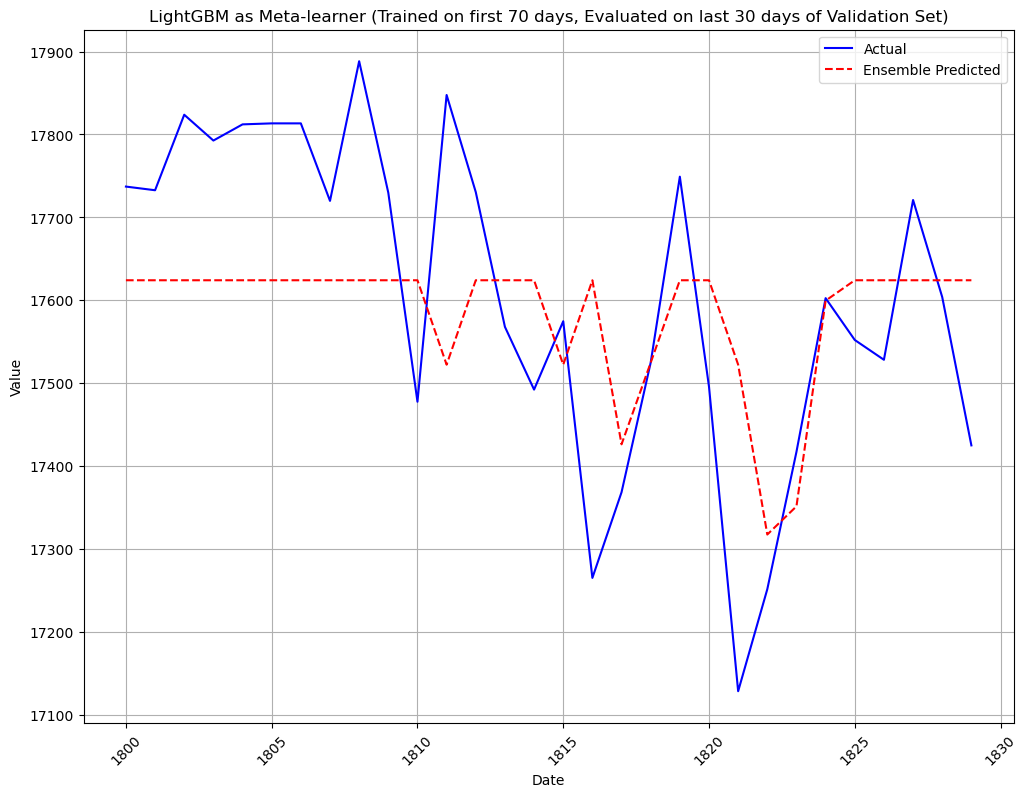

In [174]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming final_val is your dataframe with time series data
# Select the prediction columns as features for the stacking ensemble
feature_cols = [
    # 'high_lag_1', 
                # 'high_lag_2', 
                # 'low_lag_2', 
                # 'low_lag_1', 
                # 'open',
    #    'bb_lower', 'bb_upper', 'ema_20', 
    #    'sma_20', 'macd', 'macd_signal',
    #    'overall_avg_negative', 'overall_avg_positive', 
    #    'volume_lag_1',
    #    'volume_lag_2', 
       'prophet', 
       'lightgbm', 
       'xgboost', 
       'random_forest',
       'lstm', 
       'gru'
       ]

# Split the data: last 30 days for validation, rest for training
val_size = 30
X_stack_train = final_val[feature_cols].iloc[:-val_size]
y_stack_train = final_val['y'].iloc[:-val_size]
X_stack_val = final_val[feature_cols].iloc[-val_size:]
y_stack_val = final_val['y'].iloc[-val_size:]

# Define LightGBM parameters for the meta-model
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 3,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Create LightGBM dataset
train_data = lgb.Dataset(X_stack_train, label=y_stack_train)
val_data = lgb.Dataset(X_stack_val, label=y_stack_val, reference=train_data)

# Train the LightGBM meta-model
num_round = 500
bst = lgb.train(lgb_params, train_data, num_round, valid_sets=[val_data])

# Make predictions on the validation set
y_stack_pred = bst.predict(X_stack_val)

# Evaluate the model
mse = mean_squared_error(y_stack_val, y_stack_pred)
r2 = r2_score(y_stack_val, y_stack_pred)

print(f"Stacking Ensemble RMSE (Validation, last 30 days): {mse:.4f}")
print(f"Stacking Ensemble R² Score (Validation, last 30 days): {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': bst.feature_importance()
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 9))
sns.barplot(
    data=feature_importance.head(15),  # top 20 features
    x='Importance', y='Feature', palette='viridis'
)
plt.title('LightGBM as Meta-learner Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
# plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(y_stack_val.index, y_stack_val, label='Actual', color='blue')
plt.plot(y_stack_val.index, y_stack_pred, label='Ensemble Predicted', color='red', linestyle='--')
plt.title('LightGBM as Meta-learner (Trained on first 70 days, Evaluated on last 30 days of Validation Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# plt.tight_layout()

In [203]:
y_stack_pred.shape

(30,)

## Test set inference

In [175]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Load all submission files and unscale predictions
submissions = {
    'lightgbm': pd.read_csv('../submissions/lgb_submission.csv'),
    'xgboost': pd.read_csv('../submissions/xgb_submission.csv'),
    'random_forest': pd.read_csv('../submissions/rf_submission.csv'),
    'lstm': pd.read_csv('../submissions/lstm_submission.csv'),
    'gru': pd.read_csv('../submissions/gru_submission.csv')
    # Add 'prophet' if you have prophet_submission.csv
}

for name, df in submissions.items():
    df['Close'] = df['Close'] / 1e5
    df = df.sort_values('Id')  # Ensure order matches
    submissions[name] = df

# 2. Prepare test set features for stacking
# Merge all predictions by 'Id'
test_stack = submissions['lightgbm'][['Id', 'Close']].rename(columns={'Close': 'lightgbm'})
for name in ['xgboost', 'random_forest', 'lstm', 'gru']:
    test_stack = test_stack.merge(
        submissions[name][['Id', 'Close']].rename(columns={'Close': name}),
        on='Id'
    )

# If you have Prophet predictions, merge them as well
prophet_df = pd.read_csv('../submissions/prophet_submission.csv')
prophet_df['Close'] = prophet_df['Close'] / 1e5
test_stack = test_stack.merge(
    prophet_df[['Id', 'Close']].rename(columns={'Close': 'prophet'}),
    on='Id'
)

# If you want to add 'open' price as a feature, load it from X_test
test_stack['open'] = X_test['open'].values

# 3. Prepare full validation set for meta-learner retraining
# Assume final_val is available in memory and contains all model predictions (unscaled)
# If not, reload and unscale them similarly

feature_cols = [
    'prophet', 'lightgbm', 'xgboost', 'random_forest', 'lstm', 'gru'
]
# If you don't have prophet, remove it from feature_cols and test_stack

# 4. Retrain meta-learner on full validation set
X_stack_full = final_val[feature_cols]
y_stack_full = final_val['y']

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data = lgb.Dataset(X_stack_full, label=y_stack_full)

# Train meta-learner on all validation data
bst = lgb.train(lgb_params, train_data, num_boost_round=1000)

# 5. Predict on test set
# Ensure test_stack columns match feature_cols order
test_X = test_stack[feature_cols]
meta_preds = bst.predict(test_X)

# 6. Prepare final submission
final_submission = pd.DataFrame({
    'Id': test_stack['Id'],
    'Close': meta_preds * 1e5  # rescale if needed
})
final_submission = final_submission.sort_values(by='Id', ascending=True)
final_submission.to_csv('meta_ensemble_submission.csv', index=False)
print("\nMeta-ensemble submission file 'meta_ensemble_submission.csv' has been created.")

# 7. (Optional) Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': bst.feature_importance()
}).sort_values(by='Importance', ascending=False)
print("\nMeta-ensemble Feature Importance:")
print(feature_importance)


Meta-ensemble submission file 'meta_ensemble_submission.csv' has been created.

Meta-ensemble Feature Importance:
         Feature  Importance
0        prophet         533
2        xgboost         410
3  random_forest         393
5            gru         297
4           lstm         286
1       lightgbm         169


In [188]:
final_val

,ds,y,high_lag_1,high_lag_2,low_lag_2,low_lag_1,open,bb_lower,bb_upper,ema_20,...,overall_avg_negative,overall_avg_positive,volume_lag_1,volume_lag_2,prophet,xgboost,random_forest,lstm,gru,lightgbm
1730,2015-08-11,17402.83984,17629.13086,17414.93945,17279.08008,17375.17969,17593.58984,17267.141292,18218.079607,17662.089634,...,0.478342,0.113556,92430000.0,81800000.0,17575.574194,17649.833984,17670.024259,17527.599609,17573.675781,17619.648003
1731,2015-08-12,17402.50977,17593.58984,17629.13086,17375.17969,17352.63086,17382.92969,17231.453855,18186.721927,17635.502973,...,0.616617,0.059616,103010000.0,92430000.0,17397.476692,17478.173828,17499.148574,17448.263672,17461.109375,17438.410211
1732,2015-08-13,17408.25000,17423.90039,17593.58984,17352.63086,17125.81055,17401.64063,17211.344485,18139.179344,17613.230369,...,0.401260,0.143449,120400000.0,103010000.0,17390.284964,17437.416016,17473.273799,17396.425781,17417.033203,17454.959566
1733,2015-08-14,17477.40039,17481.77930,17423.90039,17125.81055,17341.33984,17410.11914,17209.603569,18070.174166,17593.886442,...,0.476225,0.072213,88550000.0,120400000.0,17425.702364,17523.798828,17436.886690,17378.718750,17427.908203,17454.959566
1734,2015-08-17,17545.17969,17492.90039,17481.77930,17341.33984,17394.06055,17472.66016,17225.571872,17992.880863,17582.341082,...,0.538568,0.092518,82120000.0,88550000.0,17465.731075,17547.443359,17529.639531,17468.173828,17481.806641,17531.722761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,2015-12-24,17552.16992,17607.91992,17451.10938,17242.85938,17427.63086,17593.25977,17167.275095,17980.251662,17520.797985,...,0.540616,0.047481,92820000.0,91570000.0,17648.194697,17607.437500,17659.893457,17556.552734,17572.568359,17587.960542
1826,2015-12-28,17528.26953,17606.33984,17607.91992,17427.63086,17543.94922,17535.66016,17167.813994,17952.674873,17522.213430,...,0.516962,0.125248,40350000.0,92820000.0,17620.681410,17554.990234,17518.293564,17546.136719,17568.218750,17506.274124
1827,2015-12-29,17720.98047,17536.90039,17606.33984,17543.94922,17437.33984,17547.36914,17171.157671,17923.784126,17524.609212,...,0.425584,0.126233,59770000.0,40350000.0,17610.167584,17551.281250,17522.500205,17497.583984,17529.310547,17521.956792
1828,2015-12-30,17603.86914,17750.01953,17536.90039,17437.33984,17547.36914,17711.93945,17171.466312,17922.697360,17542.450187,...,0.485845,0.181320,69860000.0,59770000.0,17759.756390,17710.048828,17715.872735,17609.839844,17668.988281,17718.432283
